In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
from sklearn.linear_model import LinearRegression

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1397
after merge with benchmark dates 1397
Original number of rows: 1397
Number of rows after aggregation: 967


In [5]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df1, df_cm1, df_db1 = fit_statistical_model(scores_df, anchor_benchmark=anchor_benchmark, anchor_difficulty=anchor_difficulty, anchor_slope=anchor_slope)

# Convert date strings to datetime objects
df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

# Filter to keep only models from ChatGPT era onwards (drop GPT-2 era)
START_DATE_FILTER = '2022-11-01'  # Adjust this date as needed
df_cm1 = df_cm1[df_cm1['date_obj'] >= pd.to_datetime(START_DATE_FILTER)].copy()
print(f"Filtered to {len(df_cm1)} models from {START_DATE_FILTER} onwards")

`ftol` termination condition is satisfied.
Function evaluations 25, initial cost 3.4077e+01, final cost 2.4357e+00, first-order optimality 1.37e-04.
Filtered to 136 models from 2022-11-01 onwards


In [6]:
# keep only models released before cutoff
cutoff_date = "2024-07-01"
cutoff_date = pd.to_datetime(cutoff_date)
scores_df['date'] = pd.to_datetime(scores_df['date'], errors='coerce')
scores_df_cut = scores_df[scores_df['date'] < cutoff_date]
scores_df_cut = scores_df_cut[scores_df_cut['benchmark_release_date'] < cutoff_date]
dropped_models = set(scores_df['model']) - set(scores_df_cut['model'].unique())
print(f"Models dropped by date filter: {len(dropped_models)} →", dropped_models)
dropped_benchmarks = set(scores_df['benchmark']) - set(scores_df_cut['benchmark'].unique())
print(f"Benchmarks dropped by date filter: {len(dropped_benchmarks)} →", dropped_benchmarks)

anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
df2, df_cm2, df_db2 = fit_statistical_model(scores_df_cut, anchor_benchmark=anchor_benchmark, anchor_difficulty=anchor_difficulty, anchor_slope=anchor_slope)

Models dropped by date filter: 74 → {'DeepSeek-V3', 'claude-sonnet-4-20250514', 'claude-3-7-sonnet-20250219_16K', 'claude-opus-4-20250514_16K', 'Qwen2.5-Coder-0.5B', 'claude-3-7-sonnet-20250219_32K', 'o3-2025-04-16_medium', 'gemini-2.5-flash-preview-04-17', 'Llama-3.1-405B-Instruct', 'gemini-2.5-pro-preview-05-06', 'Llama-4-Scout-17B-16E-Instruct', 'gemini-2.0-pro-exp-02-05', 'gemini-1.5-pro-002', 'o3-2025-04-16_high', 'qwen-max-2025-01-25', 'mistral-large-2411', 'gpt-4o-mini-2024-07-18', 'claude-sonnet-4-20250514_16K', 'Llama-3.2-90B-Vision-Instruct', 'o1-2024-12-17_high', 'gemini-2.0-flash-thinking-exp-01-21', 'grok-3-beta', 'claude-opus-4-20250514', 'Qwen2.5-Coder-7B', 'Llama-3.1-8B-Instruct', 'Qwen2.5-Coder-32B', 'mistral-large-2407', 'o1-mini-2024-09-12_high', 'claude-3-5-haiku-20241022', 'o4-mini-2025-04-16_medium', 'gemini-1.5-flash-002', 'Llama-4-Maverick-17B-128E-Instruct', 'o1-2024-12-17_medium', 'grok-3-mini-beta_low', 'gpt-4.1-mini-2025-04-14', 'Qwen2.5-72B', 'mistral-mediu

In [7]:
for i in [df1, df2, df_cm1, df_cm2, df_db1, df_db2]:
  print(len(i))

967
440
136
75
31
14


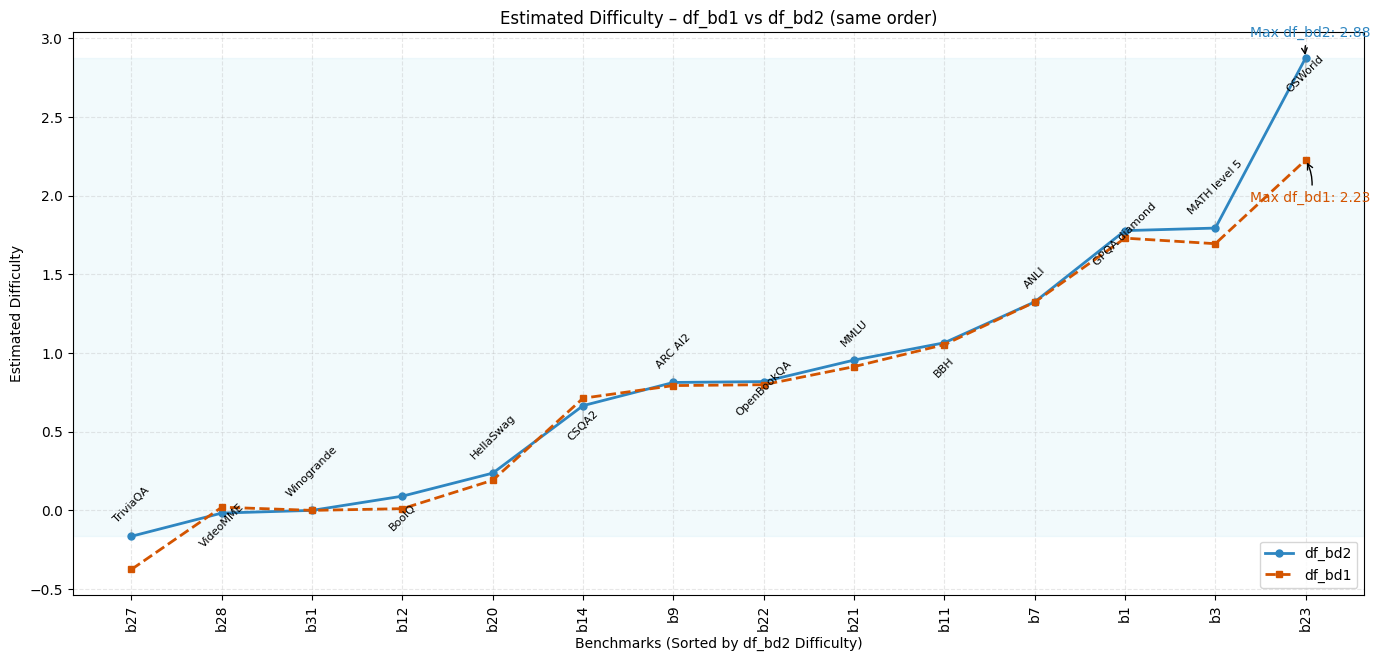

In [8]:
# --- 1. Sort df_db2 exactly as before ----------------------------------------
sorted_df2 = df_db2.sort_values(by="estimated_difficulty").reset_index(drop=True)

# --- 2. Align df_bd1 to that order -------------------------------------------
#   (will silently insert NaN if df_bd1 is missing a benchmark_id)
aligned_df1 = (
    df_db1                      # original
    .set_index("benchmark_id")  # use benchmark_id as index
    .reindex(sorted_df2["benchmark_id"])  # re-order / align
    .reset_index()              # restore column shape
)

# --- 3. Grab the columns you need -------------------------------------------
x              = np.arange(len(sorted_df2))                 # shared x-axis
y2_difficulty  = sorted_df2["estimated_difficulty"].values   # df_bd2 (sorted)
y1_difficulty  = aligned_df1["estimated_difficulty"].values  # df_bd1 (aligned)
bench_ids      = sorted_df2["benchmark_id"].values
bench_names    = sorted_df2["benchmark_name"].values

# --- 4. Plot -----------------------------------------------------------------
plt.figure(figsize=(14, 8))

# df_bd2 (your original line)
plt.plot(
    x, y2_difficulty,
    marker='o', linestyle='-', linewidth=2, markersize=5,
    color='#2E86C1', label='df_bd2'
)

# df_bd1 (second line – tweak style/colour as you like)
plt.plot(
    x, y1_difficulty,
    marker='s', linestyle='--', linewidth=2, markersize=5,
    color='#D35400', label='df_bd1'
)

# --- 5. Cosmetics (labels, grid, ticks, annotations) -------------------------
plt.xlabel('Benchmarks (Sorted by df_bd2 Difficulty)')
plt.ylabel('Estimated Difficulty')
plt.title('Estimated Difficulty – df_bd1 vs df_bd2 (same order)')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, bench_ids, rotation=90)

# (Optional) annotate benchmark names just once to avoid clutter
for i, (diff, name) in enumerate(zip(y2_difficulty, bench_names)):
    y_offset = 10 if i % 2 == 0 else -25
    plt.annotate(
        name,
        xy=(i, diff),
        xytext=(0, y_offset),
        textcoords='offset points',
        ha='center', fontsize=8, rotation=45,
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
    )

# Add legend to distinguish the two data sources
plt.legend()

# Light background band (optional)
plt.axhspan(y2_difficulty.min(), y2_difficulty.max(), alpha=0.1, color='skyblue')

# Min/Max annotations for each line (optional but illustrative)
plt.annotate(f'Max df_bd2: {y2_difficulty.max():.2f}',
             xy=(x[y2_difficulty.argmax()], y2_difficulty.max()),
             xytext=(-40, 15), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
             color='#2E86C1')

plt.annotate(f'Max df_bd1: {np.nanmax(y1_difficulty):.2f}',
             xy=(x[np.nanargmax(y1_difficulty)], np.nanmax(y1_difficulty)),
             xytext=(-40, -30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
             color='#D35400')

# Make room for rotated x-labels
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

plt.show()


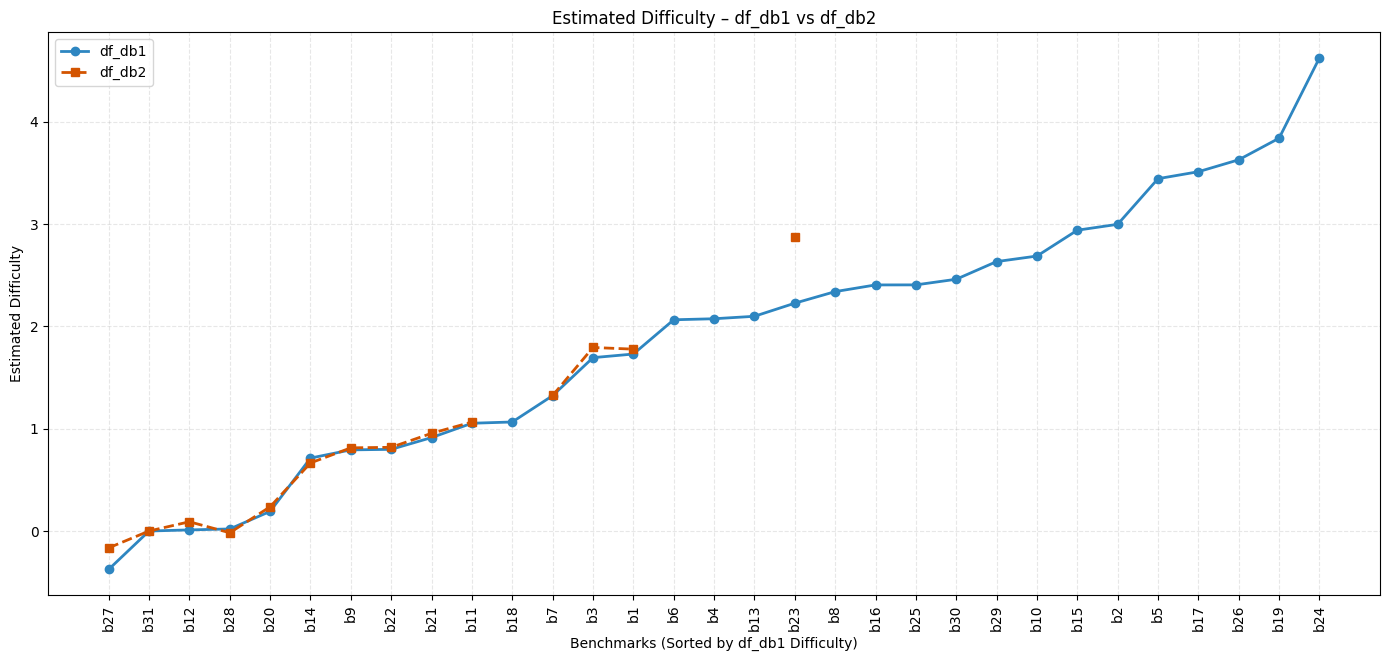

In [9]:
# ──────────────────────────────────────────────────────────────
# 1. Sort df_db1 by difficulty (defines x-axis order)
# ──────────────────────────────────────────────────────────────
sorted_df1 = (
    df_db1
    .sort_values(by="estimated_difficulty")
    .reset_index(drop=True)
)

# ──────────────────────────────────────────────────────────────
# 2. (Optional) deduplicate df_db2 on benchmark_id
#     – keeps the HIGHEST difficulty row per benchmark_id
#       (swap for mean/median if you prefer)
# ──────────────────────────────────────────────────────────────
df_db2_dedup = (
    df_db2
    .sort_values("estimated_difficulty", ascending=False)  # largest first
    .drop_duplicates(subset="benchmark_id", keep="first")
)

# ──────────────────────────────────────────────────────────────
# 3. Align df_db2 to df_db1 order
#    Any benchmark missing in df_db2 becomes NaN
# ──────────────────────────────────────────────────────────────
aligned_df2 = (
    df_db2_dedup
    .set_index("benchmark_id")
    .reindex(sorted_df1["benchmark_id"])   # align to df_db1
    .reset_index()
)

# ──────────────────────────────────────────────────────────────
# 4. Prepare data for plotting
# ──────────────────────────────────────────────────────────────
x  = np.arange(len(sorted_df1))                       # shared x-coords
y1 = sorted_df1["estimated_difficulty"].values        # df_db1 values
y2 = aligned_df2["estimated_difficulty"].values       # df_db2 values (aligned)

bench_ids   = sorted_df1["benchmark_id"].values
bench_names = sorted_df1["benchmark_name"].values     # if you want labels

# ──────────────────────────────────────────────────────────────
# 5. Plot
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 8))

plt.plot(x, y1, marker='o', linestyle='-', linewidth=2, markersize=6,
         color='#2E86C1', label='df_db1')
plt.plot(x, y2, marker='s', linestyle='--', linewidth=2, markersize=6,
         color='#D35400', label='df_db2')

plt.xlabel('Benchmarks (Sorted by df_db1 Difficulty)')
plt.ylabel('Estimated Difficulty')
plt.title('Estimated Difficulty – df_db1 vs df_db2')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, bench_ids, rotation=90)
plt.legend()

# # Optional annotation block (commented-out to keep the plot clean)
# for i, (diff, name) in enumerate(zip(y1, bench_names)):
#     y_offset = 10 if i % 2 == 0 else -25
#     plt.annotate(
#         name,
#         xy=(i, diff),
#         xytext=(0, y_offset),
#         textcoords='offset points',
#         ha='center', fontsize=8, rotation=45,
#         arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
#     )

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # room for rotated labels
plt.show()


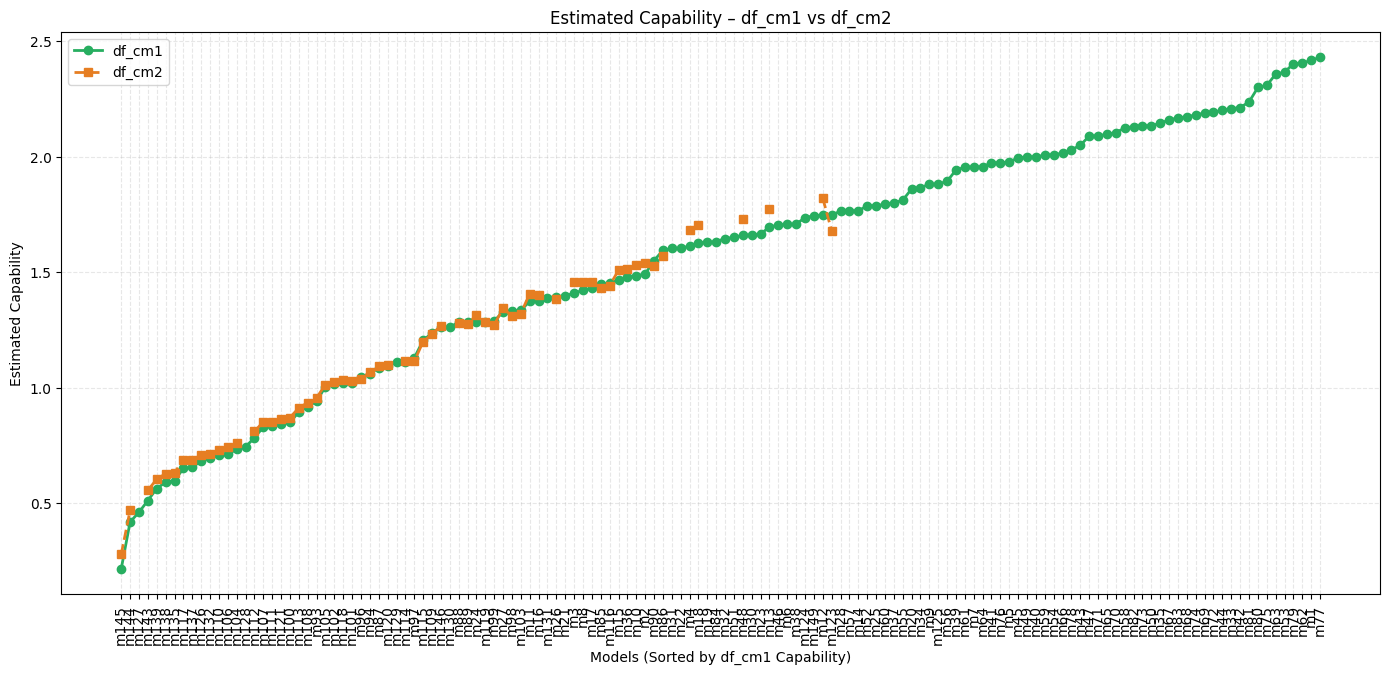

In [96]:
# ──────────────────────────────────────────────────────────────
# 1. Sort df_cm1 by capability (this defines the x-axis order)
# ──────────────────────────────────────────────────────────────
sorted_df1 = (
    df_cm1
    .sort_values(by="estimated_capability")
    .reset_index(drop=True)
)

# ──────────────────────────────────────────────────────────────
# 2. Remove duplicate model_id rows in df_cm2
#    (keep the row with the highest capability for each model_id)
#    ──> swap this block out if you prefer a mean/median instead
# ──────────────────────────────────────────────────────────────
df_cm2_dedup = (
    df_cm2
    .sort_values("estimated_capability", ascending=False)  # biggest first
    .drop_duplicates(subset="model_id", keep="first")      # keep that row
)

# Optional sanity check – uncomment to see what was removed:
# dupes = df_cm2[df_cm2.duplicated('model_id', keep=False)]
# print(f"Found {len(dupes)} duplicate rows in df_cm2"); dupes.head()

# ──────────────────────────────────────────────────────────────
# 3. Align df_cm2 (deduped) to the df_cm1 order
#    Any model_id missing from df_cm2 becomes NaN (gap in the line)
# ──────────────────────────────────────────────────────────────
aligned_df2 = (
    df_cm2_dedup
    .set_index("model_id")
    .reindex(sorted_df1["model_id"])   # align to df_cm1 order
    .reset_index()
)

# ──────────────────────────────────────────────────────────────
# 4. Prepare data for plotting
# ──────────────────────────────────────────────────────────────
x  = np.arange(len(sorted_df1))                      # shared x-coords
y1 = sorted_df1["estimated_capability"].values       # df_cm1 values
y2 = aligned_df2["estimated_capability"].values      # df_cm2 values (aligned)

model_ids   = sorted_df1["model_id"].values
model_names = sorted_df1["model"].values

# ──────────────────────────────────────────────────────────────
# 5. Plot
# ──────────────────────────────────────────────────────────────
plt.figure(figsize=(14, 8))

plt.plot(x, y1, marker='o', linestyle='-', linewidth=2, markersize=6,
         color='#27AE60', label='df_cm1')
plt.plot(x, y2, marker='s', linestyle='--', linewidth=2, markersize=6,
         color='#E67E22', label='df_cm2')

plt.xlabel('Models (Sorted by df_cm1 Capability)')
plt.ylabel('Estimated Capability')
plt.title('Estimated Capability – df_cm1 vs df_cm2')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(x, model_ids, rotation=90)
plt.legend()

# #   Annotate each point once (using df_cm1) to avoid clutter
# for i, (cap, name) in enumerate(zip(y1, model_names)):
#     y_offset = 10 if i % 2 == 0 else -25
#     plt.annotate(
#         name,
#         xy=(i, cap),
#         xytext=(0, y_offset),
#         textcoords='offset points',
#         ha='center', fontsize=8, rotation=45,
#         arrowprops=dict(arrowstyle='-', color='gray', alpha=0.4)
#     )

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # room for rotated x-labels
plt.show()


# Forecasting Analysis

The following cells contain functions and analyses for forecasting frontier AI capabilities.


In [10]:
from pathlib import Path
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Define helper functions inline (to avoid import issues)
def prepare_model_data(df_capabilities: pd.DataFrame) -> pd.DataFrame:
    """Prepare model capabilities data with datetime conversion"""
    df = df_capabilities.copy()
    df['date_obj'] = pd.to_datetime(df['date'])
    return df.sort_values('date_obj')

def filter_by_date(df: pd.DataFrame, 
                  date_col: str, 
                  cutoff_date: str,
                  before: bool = True) -> pd.DataFrame:
    """Filter dataframe by date"""
    cutoff = pd.to_datetime(cutoff_date)
    if before:
        return df[df[date_col] <= cutoff].copy()
    else:
        return df[df[date_col] > cutoff].copy()

def bootstrap_slope_analysis(df: pd.DataFrame, 
                           x_col: str, 
                           y_col: str, 
                           n_bootstrap: int = 10000) -> dict:
    """Perform bootstrap analysis to estimate slope with confidence intervals"""
    # Convert dates to numeric if needed
    if df[x_col].dtype == 'datetime64[ns]':
        x_numeric = (df[x_col] - df[x_col].min()).dt.days
    else:
        x_numeric = df[x_col]
    
    # Bootstrap sampling
    slopes = []
    for _ in range(n_bootstrap):
        sample_idx = np.random.choice(len(df), size=len(df), replace=True)
        x_sample = x_numeric.iloc[sample_idx].values.reshape(-1, 1)
        y_sample = df[y_col].iloc[sample_idx].values
        
        model = LinearRegression()
        model.fit(x_sample, y_sample)
        
        # Convert slope to per-year if using days
        slope = model.coef_[0]
        if df[x_col].dtype == 'datetime64[ns]':
            slope *= 365.25  # Convert from per-day to per-year
            
        slopes.append(slope)
    
    slopes = np.array(slopes)
    
    return {
        'mean_slope': np.mean(slopes),
        'std_slope': np.std(slopes),
        'ci_2_5': np.percentile(slopes, 2.5),
        'ci_97_5': np.percentile(slopes, 97.5)
    }


## 1. Forecast Validation

This function validates forecast accuracy by comparing pre-cutoff predictions to post-cutoff reality.


In [11]:
def validate_forecast_accuracy(df_capabilities: pd.DataFrame, 
                             cutoff_date: str,
                             top_n_models: int,
                             label_frontier: bool = False):
    """Validate forecast accuracy by comparing pre-cutoff predictions to post-cutoff reality"""
    print(f"Validating forecast accuracy with cutoff date: {cutoff_date} using models that were top {top_n_models} at release")
    
    df = prepare_model_data(df_capabilities)
    cutoff_dt = pd.to_datetime(cutoff_date)
    
    # Get all data for context plots
    pre_cutoff_all = filter_by_date(df, 'date_obj', cutoff_date, before=True)
    post_cutoff_all = filter_by_date(df, 'date_obj', cutoff_date, before=False)
    
    # Identify frontier models using the same logic as create_future_forecast
    # But only use pre-cutoff data for training
    frontier_models_pre = []
    frontier_models_post = []
    
    for _, model in df.iterrows():
        model_release_date = model['date_obj']
        
        # Find all models that existed at or before this model's release date
        available_models = df[df['date_obj'] <= model_release_date]
        
        # Check if this model was among the top N at its release time
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            if model_release_date <= cutoff_dt:
                frontier_models_pre.append(model)
            else:
                frontier_models_post.append(model)
    
    pre_cutoff = pd.DataFrame(frontier_models_pre)
    post_cutoff = pd.DataFrame(frontier_models_post)
    
    if len(pre_cutoff) == 0 or len(post_cutoff) == 0:
        print("Insufficient data for validation - skipping accuracy analysis")
        return {}
    
    # Fit model on pre-cutoff data
    X_pre = (pre_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pre = pre_cutoff['estimated_capability'].values
    
    model = LinearRegression()
    model.fit(X_pre, y_pre)
    
    # Make predictions for post-cutoff dates
    X_post = (post_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pred = model.predict(X_post)
    y_actual = post_cutoff['estimated_capability'].values
    
    # Calculate accuracy metrics
    mae = np.mean(np.abs(y_pred - y_actual))
    rmse = np.sqrt(np.mean((y_pred - y_actual)**2))
    r2 = 1 - np.sum((y_actual - y_pred)**2) / np.sum((y_actual - np.mean(y_actual))**2)
    
    # Create validation plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all models (faded) for context
    ax.scatter(pre_cutoff_all['date_obj'], pre_cutoff_all['estimated_capability'], 
              alpha=0.2, s=20, label='All models (pre-cutoff)', color='lightblue')
    ax.scatter(post_cutoff_all['date_obj'], post_cutoff_all['estimated_capability'], 
              alpha=0.2, s=20, label='All models (post-cutoff)', color='lightgreen')
    
    # Plot frontier models
    ax.scatter(pre_cutoff['date_obj'], pre_cutoff['estimated_capability'], 
              alpha=0.8, s=50, label=f'Frontier models (pre-cutoff)', color='blue')
    
    ax.scatter(post_cutoff['date_obj'], post_cutoff['estimated_capability'], 
              alpha=0.8, s=50, label=f'Frontier models (actual)', color='green')

    # Optional labels for frontier models
    if label_frontier:
        for _, r in pre_cutoff.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color='blue',
                alpha=0.9,
            )
        for _, r in post_cutoff.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color='green',
                alpha=0.9,
            )
    
    # Plot predictions
    ax.scatter(post_cutoff['date_obj'], y_pred, 
              alpha=0.7, s=50, marker='x', label='Predicted', color='red')
    
    # Plot trend line
    all_dates = pd.concat([pre_cutoff['date_obj'], post_cutoff['date_obj']])
    X_all = (all_dates - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_trend = model.predict(X_all)
    ax.plot(all_dates, y_trend, 'r--', alpha=0.7, label='Trend line')
    
    # Add cutoff line
    ax.axvline(x=cutoff_dt, color='black', linestyle=':', alpha=0.7, label='Cutoff date')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier Forecast Validation (Models that were Top {top_n_models} at Release, Cutoff: {cutoff_date})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'n_training': len(pre_cutoff),
        'n_validation': len(post_cutoff),
        'slope': model.coef_[0] * 365.25,  # Convert to per-year
        'intercept': model.intercept_
    }


## 2. Future Forecast

This function creates forecasts for future capabilities based on models that were frontier at release.


In [12]:
def create_future_forecast(df_capabilities: pd.DataFrame,
                         forecast_years: int = 3,
                         top_n_models: int = 1,
                         label_frontier: bool = False):
    """Create forecast for future capabilities based on models that were frontier at release"""
    print(f"Creating {forecast_years}-year capability forecast using models that were top {top_n_models} at release...")
    
    df = prepare_model_data(df_capabilities)
    
    # Identify frontier models: those that were among top N when they were released
    frontier_models = []
    
    for _, model in df.iterrows():
        model_release_date = model['date_obj']
        model_capability = model['estimated_capability']
        
        # Find all models that existed at or before this model's release date
        available_models = df[df['date_obj'] <= model_release_date]
        
        # Check if this model was among the top N at its release time
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            frontier_models.append(model)
    
    # Convert to DataFrame
    df_frontier = pd.DataFrame(frontier_models)
    
    print(f"Using {len(df_frontier)} frontier model data points (from {len(df)} total)")
    print(f"Frontier models: {', '.join(df_frontier.nsmallest(10, 'date_obj')['model'].tolist())}")
    
    # Prepare data for modeling using only frontier models
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    
    # Fit linear model
    model = LinearRegression()
    model.fit(X, y)
    
    # Also fit with statsmodels for confidence intervals
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    
    # Create forecast dates
    last_date = df['date_obj'].max()
    forecast_end = last_date + timedelta(days=365.25 * forecast_years)
    forecast_dates = pd.date_range(start=last_date, end=forecast_end, freq='ME')
    
    # Convert forecast dates to numeric
    X_forecast = (forecast_dates - df['date_obj'].min()).days.values.reshape(-1, 1)
    X_forecast_sm = sm.add_constant(X_forecast.flatten())
    
    # Make predictions
    y_forecast = model.predict(X_forecast)
    
    # Get confidence and prediction intervals from statsmodels
    forecast_sm = model_sm.get_prediction(X_forecast_sm)
    ci_lower = forecast_sm.conf_int()[:, 0]
    ci_upper = forecast_sm.conf_int()[:, 1]
    
    # Get prediction intervals - handle different statsmodels versions
    try:
        pi_lower = forecast_sm.prediction_interval[:, 0]
        pi_upper = forecast_sm.prediction_interval[:, 1]
    except AttributeError:
        # Fallback for older statsmodels versions or manual calculation
        prediction_std_err = forecast_sm.se_mean
        t_val = stats.t.ppf(0.975, model_sm.df_resid)  # 95% prediction interval
        pi_lower = y_forecast - t_val * prediction_std_err
        pi_upper = y_forecast + t_val * prediction_std_err
    
    # Create comprehensive forecast plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot all historical data (faded)
    ax.scatter(df['date_obj'], df['estimated_capability'], 
              alpha=0.3, s=20, label='All models', color='lightblue')
    
    # Plot frontier models data (highlighted)
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
              alpha=0.8, s=40, label=f'Models that were top {top_n_models} at release', color='blue')

    # Optional labels for frontier models
    if label_frontier:
        for _, r in df_frontier.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color='blue',
                alpha=0.9,
            )
    
    # Plot historical trend (based on frontier models)
    y_hist_trend = model.predict(X)
    ax.plot(df_frontier['date_obj'], y_hist_trend, 'b--', alpha=0.7, label='Frontier trend')
    
    # Plot forecast
    ax.plot(forecast_dates, y_forecast, 'r-', linewidth=2, label='Forecast')
    
    # Plot confidence intervals
    ax.fill_between(forecast_dates, ci_lower, ci_upper, 
                   alpha=0.3, color='red', label='95% Confidence interval')
    
    # Plot prediction intervals
    ax.fill_between(forecast_dates, pi_lower, pi_upper, 
                   alpha=0.2, color='red', label='95% Prediction interval')
    
    # Add vertical line for present
    ax.axvline(x=last_date, color='black', linestyle=':', alpha=0.7, label='Present')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'{forecast_years}-Year AI Frontier Capability Forecast (Models that were Top {top_n_models} at Release)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # Create forecast table
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'predicted_capability': y_forecast,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'pi_lower': pi_lower,
        'pi_upper': pi_upper
    })
    
    return {
        'model': model,
        'forecast_df': forecast_df,
        'slope_per_year': model.coef_[0] * 365.25,
        'r2': model.score(X, y),
        'model_summary': model_sm.summary()
    }


## 3. Post-Cutoff Frontier Forecast

This function creates a forecast using only post-cutoff frontier models.


In [13]:
def create_post_cutoff_frontier_forecast(
    df_capabilities: pd.DataFrame,
    cutoff_date: str,
    forecast_years: int = 3,
    top_n_models: int = 1,
    label_frontier: bool = False,
):
    """Create a post-cutoff forecast using only models that were frontier at release AFTER the cutoff."""
    print(
        f"Creating post-cutoff ({cutoff_date}) {forecast_years}-year forecast using models that were top {top_n_models} at release..."
    )

    df = prepare_model_data(df_capabilities)
    cutoff_dt = pd.to_datetime(cutoff_date)

    # Identify post-cutoff frontier models
    post_cutoff_frontier_models = []

    for _, model_row in df.iterrows():
        model_release_date = model_row['date_obj']
        if pd.isna(model_release_date) or pd.isna(model_row['estimated_capability']):
            continue

        if model_release_date <= cutoff_dt:
            continue

        available_models = df[df['date_obj'] <= model_release_date]
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')

        if model_row['model'] in top_models_at_release['model'].values:
            post_cutoff_frontier_models.append(model_row)

    df_frontier_post = pd.DataFrame(post_cutoff_frontier_models)

    if len(df_frontier_post) < 2:
        print("Insufficient post-cutoff frontier data points to fit a trend. Skipping post-cutoff forecast plot.")
        return {}

    # Prepare numeric features from post-cutoff data only
    x0 = df_frontier_post['date_obj'].min()
    X = (df_frontier_post['date_obj'] - x0).dt.days.values.reshape(-1, 1)
    y = df_frontier_post['estimated_capability'].values

    # Fit models
    lr_model = LinearRegression()
    lr_model.fit(X, y)

    X_sm = sm.add_constant(X.flatten())
    ols_model = sm.OLS(y, X_sm).fit()

    # Forecast horizon based on latest available date in the full dataset
    last_date = df['date_obj'].max()
    forecast_end = last_date + timedelta(days=365.25 * forecast_years)
    forecast_dates = pd.date_range(start=last_date, end=forecast_end, freq='ME')

    # Use the same baseline (x0) for conversion to numeric
    X_forecast = (forecast_dates - x0).days.values.reshape(-1, 1)
    X_forecast_sm = sm.add_constant(X_forecast.flatten())

    # Predictions
    y_hist_trend = lr_model.predict(X)
    y_forecast = lr_model.predict(X_forecast)

    # Confidence and prediction intervals via statsmodels
    forecast_sm = ols_model.get_prediction(X_forecast_sm)
    ci_lower = forecast_sm.conf_int()[:, 0]
    ci_upper = forecast_sm.conf_int()[:, 1]

    try:
        pi_lower = forecast_sm.prediction_interval[:, 0]
        pi_upper = forecast_sm.prediction_interval[:, 1]
    except AttributeError:
        prediction_std_err = forecast_sm.se_mean
        t_val = stats.t.ppf(0.975, ols_model.df_resid)
        pi_lower = y_forecast - t_val * prediction_std_err
        pi_upper = y_forecast + t_val * prediction_std_err

    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Context: all models
    ax.scatter(
        df['date_obj'],
        df['estimated_capability'],
        alpha=0.25,
        s=20,
        label='All models',
        color='lightblue',
    )

    # Highlight: post-cutoff frontier models used for fit
    ax.scatter(
        df_frontier_post['date_obj'],
        df_frontier_post['estimated_capability'],
        alpha=0.9,
        s=50,
        label=f'Post-cutoff models that were top {top_n_models} at release',
        color='blue',
    )

    # Optional labels for frontier models (post-cutoff)
    if label_frontier:
        for _, r in df_frontier_post.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color='blue',
                alpha=0.9,
            )

    # Trend on the post-cutoff segment
    ax.plot(
        df_frontier_post['date_obj'], y_hist_trend, 'b--', alpha=0.8, label='Post-cutoff frontier trend'
    )

    # Forecast and intervals
    ax.plot(forecast_dates, y_forecast, 'r-', linewidth=2, label='Post-cutoff forecast')
    ax.fill_between(
        forecast_dates, ci_lower, ci_upper, alpha=0.3, color='red', label='95% Confidence interval'
    )
    ax.fill_between(
        forecast_dates, pi_lower, pi_upper, alpha=0.2, color='red', label='95% Prediction interval'
    )

    # Lines for cutoff and present
    ax.axvline(x=cutoff_dt, color='black', linestyle=':', alpha=0.7, label='Cutoff date')
    ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='Present')

    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(
        f'Post-cutoff Frontier Forecast (Top {top_n_models} at Release after {cutoff_date}, +{forecast_years}y)'
    )
    ax.grid(True, alpha=0.3)
    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save
    forecast_df = pd.DataFrame(
        {
            'date': forecast_dates,
            'predicted_capability': y_forecast,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'pi_lower': pi_lower,
            'pi_upper': pi_upper,
        }
    )

    return {
        'model': lr_model,
        'forecast_df': forecast_df,
        'slope_per_year': lr_model.coef_[0] * 365.25,
        'r2': lr_model.score(X, y),
        'model_summary': ols_model.summary(),
        'n_points': len(df_frontier_post),
    }


## 4. Benchmark Saturation Forecasts

This function forecasts when models will reach 50% performance on different benchmarks.


In [14]:
def analyze_benchmark_saturation_forecasts(df_capabilities: pd.DataFrame,
                                         df_benchmarks: pd.DataFrame):
    """Forecast when models will reach 50% performance on different benchmarks"""
    print("Analyzing benchmark saturation forecasts...")
    
    # Get capability growth rate
    df_cap = prepare_model_data(df_capabilities)
    # Remove rows with NaN values in date or estimated_capability
    df_cap_clean = df_cap.dropna(subset=['date_obj', 'estimated_capability'])
    growth_stats = bootstrap_slope_analysis(df_cap_clean, 'date_obj', 'estimated_capability')
    annual_growth = growth_stats['mean_slope']
    
    # Current maximum capability
    current_max_capability = df_cap_clean['estimated_capability'].max()
    current_date = df_cap_clean['date_obj'].max()
    
    # For each benchmark, estimate when 50% performance will be reached
    saturation_forecasts = []
    
    for _, benchmark in df_benchmarks.iterrows():
        difficulty = benchmark['estimated_difficulty']
        
        # When C_m - D_b = 0, sigmoid gives 50% performance
        capability_needed = difficulty
        
        if capability_needed > current_max_capability:
            # Calculate time needed
            capability_gap = capability_needed - current_max_capability
            years_needed = capability_gap / annual_growth
            saturation_date = current_date + timedelta(days=365.25 * years_needed)
        else:
            # Already achievable
            saturation_date = current_date
            years_needed = 0
        
        saturation_forecasts.append({
            'benchmark': benchmark['benchmark_name'],
            'difficulty': difficulty,
            'capability_needed': capability_needed,
            'years_to_saturation': years_needed,
            'predicted_saturation_date': saturation_date
        })
    
    # Convert to DataFrame and sort by years needed
    saturation_df = pd.DataFrame(saturation_forecasts)
    saturation_df = saturation_df.sort_values('years_to_saturation')
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot for benchmarks that will be saturated within 5 years
    near_term = saturation_df[saturation_df['years_to_saturation'] <= 5]
    
    if len(near_term) > 0:
        y_pos = np.arange(len(near_term))
        bars = ax.barh(y_pos, near_term['years_to_saturation'])
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(near_term['benchmark'])
        ax.set_xlabel('Years to 50% Saturation')
        ax.set_title('Predicted Benchmark Saturation Timeline (Next 5 Years)')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add current date reference
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Present')
        ax.legend()
    
    plt.tight_layout()
    
    return saturation_df


---
## Run Analysis

Now let's run all the forecasting analyses using the fitted model data from the earlier cells.


### Set Analysis Parameters


In [15]:
# Analysis parameters
CUTOFF_DATE = '2024-07-01'  # Date for validation split
FORECAST_YEARS = 3  # Number of years to forecast ahead
TOP_N_MODELS = 1  # Number of top models at release to use for frontier (1 = pure frontier)
LABEL_FRONTIER = False  # Whether to annotate frontier model names on plots


### 1. Run Forecast Validation


Validating forecast accuracy with cutoff date: 2024-07-01 using models that were top 1 at release

Validation Results (cutoff: 2024-07-01):
  MAE: 0.247
  RMSE: 0.259
  R²: -0.930
  Annual growth rate: 0.380
  Training points: 7
  Validation points: 7


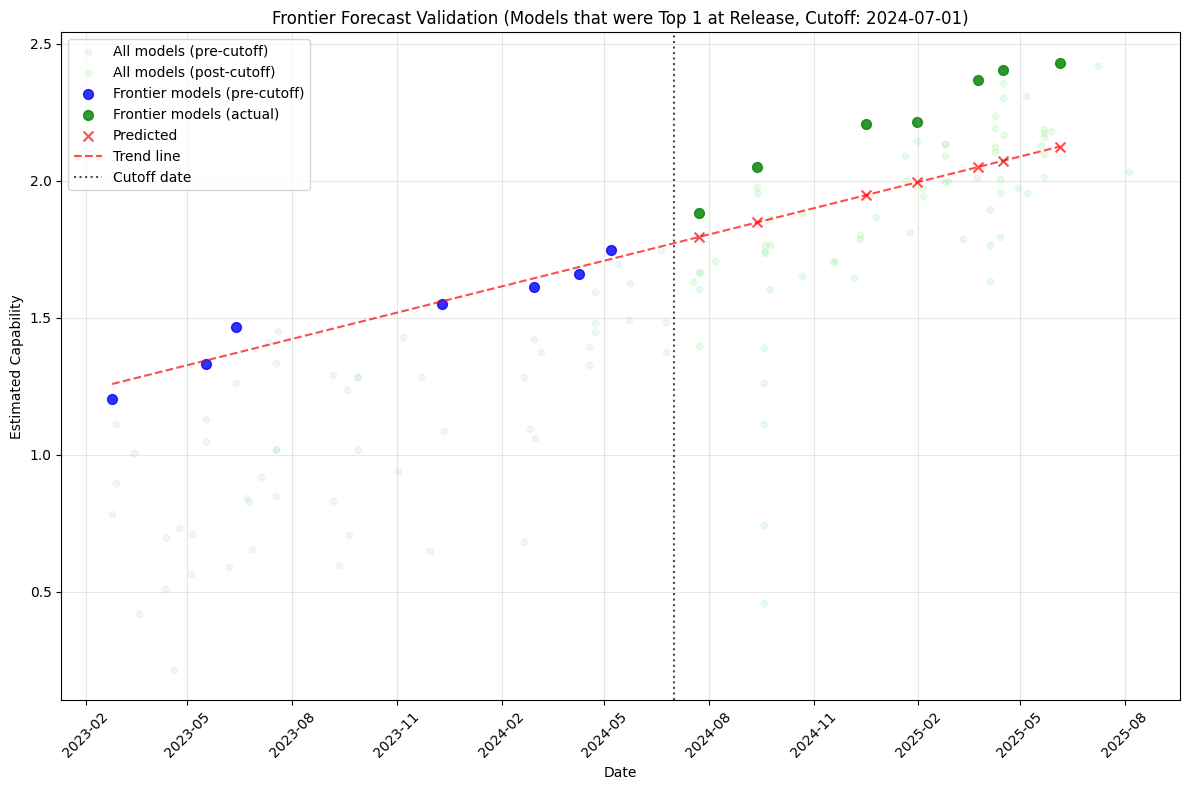

In [16]:
# Validate forecast accuracy using df_cm1 (full dataset)
validation_results = validate_forecast_accuracy(
    df_cm1, 
    CUTOFF_DATE, 
    TOP_N_MODELS, 
    label_frontier=LABEL_FRONTIER
)

if validation_results:
    print(f"\nValidation Results (cutoff: {CUTOFF_DATE}):")
    print(f"  MAE: {validation_results['mae']:.3f}")
    print(f"  RMSE: {validation_results['rmse']:.3f}")
    print(f"  R²: {validation_results['r2']:.3f}")
    print(f"  Annual growth rate: {validation_results['slope']:.3f}")
    print(f"  Training points: {validation_results['n_training']}")
    print(f"  Validation points: {validation_results['n_validation']}")


### 2. Create Future Forecast


Creating 3-year capability forecast using models that were top 1 at release...
Using 14 frontier model data points (from 136 total)
Frontier models: LLaMA-65B, PaLM 2-L, gpt-4-0613, Mixtral-8x7B-v0.1, claude-3-opus-20240229, gpt-4-turbo-2024-04-09, DeepSeek-V2, Llama-3.1-405B, o1-mini-2024-09-12_high, o1-2024-12-17_medium

Frontier Forecast (3 years, models that were top 1 at release):
  Annual growth rate: 0.546
  Model R²: 0.968

Forecast table (first 12 months):


,date,predicted_capability,ci_lower,ci_upper,pi_lower,pi_upper
0,2025-08-31,2.544540,2.454565,2.634514,2.454565,2.634514
1,2025-09-30,2.589424,2.494954,2.683893,2.494954,2.683893
2,2025-10-31,2.635803,2.536622,2.734985,2.536622,2.734985
3,2025-11-30,2.680687,2.576889,2.784486,2.576889,2.784486
4,2025-12-31,2.727067,2.618447,2.835687,2.618447,2.835687
5,2026-01-31,2.773447,2.659960,2.886934,2.659960,2.886934
6,2026-02-28,2.815339,2.697422,2.933255,2.697422,2.933255
7,2026-03-31,2.861719,2.738864,2.984573,2.738864,2.984573
8,2026-04-30,2.906602,2.778939,3.034265,2.778939,3.034265
9,2026-05-31,2.952982,2.820323,3.085641,2.820323,3.085641


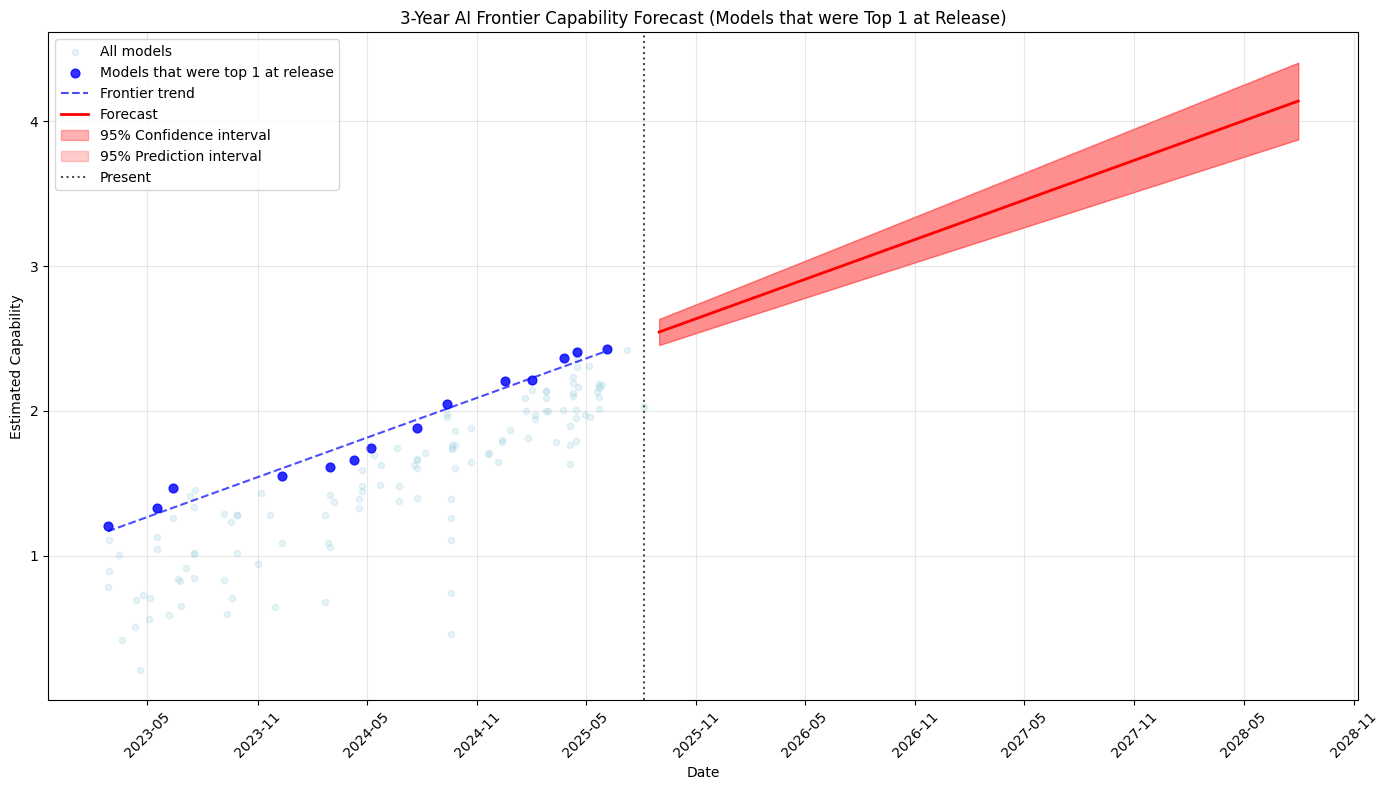

In [17]:
# Create future forecast using df_cm1 (full dataset)
forecast_results = create_future_forecast(
    df_cm1, 
    FORECAST_YEARS, 
    TOP_N_MODELS, 
    label_frontier=LABEL_FRONTIER
)

print(f"\nFrontier Forecast ({FORECAST_YEARS} years, models that were top {TOP_N_MODELS} at release):")
print(f"  Annual growth rate: {forecast_results['slope_per_year']:.3f}")
print(f"  Model R²: {forecast_results['r2']:.3f}")

# Display forecast table
print("\nForecast table (first 12 months):")
display(forecast_results['forecast_df'].head(12))


### 3. Create Post-Cutoff Frontier Forecast


Creating post-cutoff (2024-07-01) 3-year forecast using models that were top 1 at release...

Post-cutoff Frontier Forecast (after 2024-07-01, top 1 at release, 3 years):
  Points used: 7
  Annual growth rate: 0.624
  Model R²: 0.966

Post-cutoff forecast table (first 12 months):


/Users/ansonho/Documents/github/benchmark-stitching/benchmark_stitching_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


,date,predicted_capability,ci_lower,ci_upper,pi_lower,pi_upper
0,2025-08-31,2.615060,2.521727,2.708392,2.521727,2.708392
1,2025-09-30,2.666305,2.562866,2.769745,2.562866,2.769745
2,2025-10-31,2.719259,2.605194,2.833325,2.605194,2.833325
3,2025-11-30,2.770505,2.646026,2.894985,2.646026,2.894985
4,2025-12-31,2.823459,2.688114,2.958804,2.688114,2.958804
5,2026-01-31,2.876413,2.730120,3.022705,2.730120,3.022705
6,2026-02-28,2.924242,2.768005,3.080479,2.768005,3.080479
7,2026-03-31,2.977196,2.809899,3.144494,2.809899,3.144494
8,2026-04-30,3.028442,2.850399,3.206485,2.850399,3.206485
9,2026-05-31,3.081396,2.892214,3.270577,2.892214,3.270577


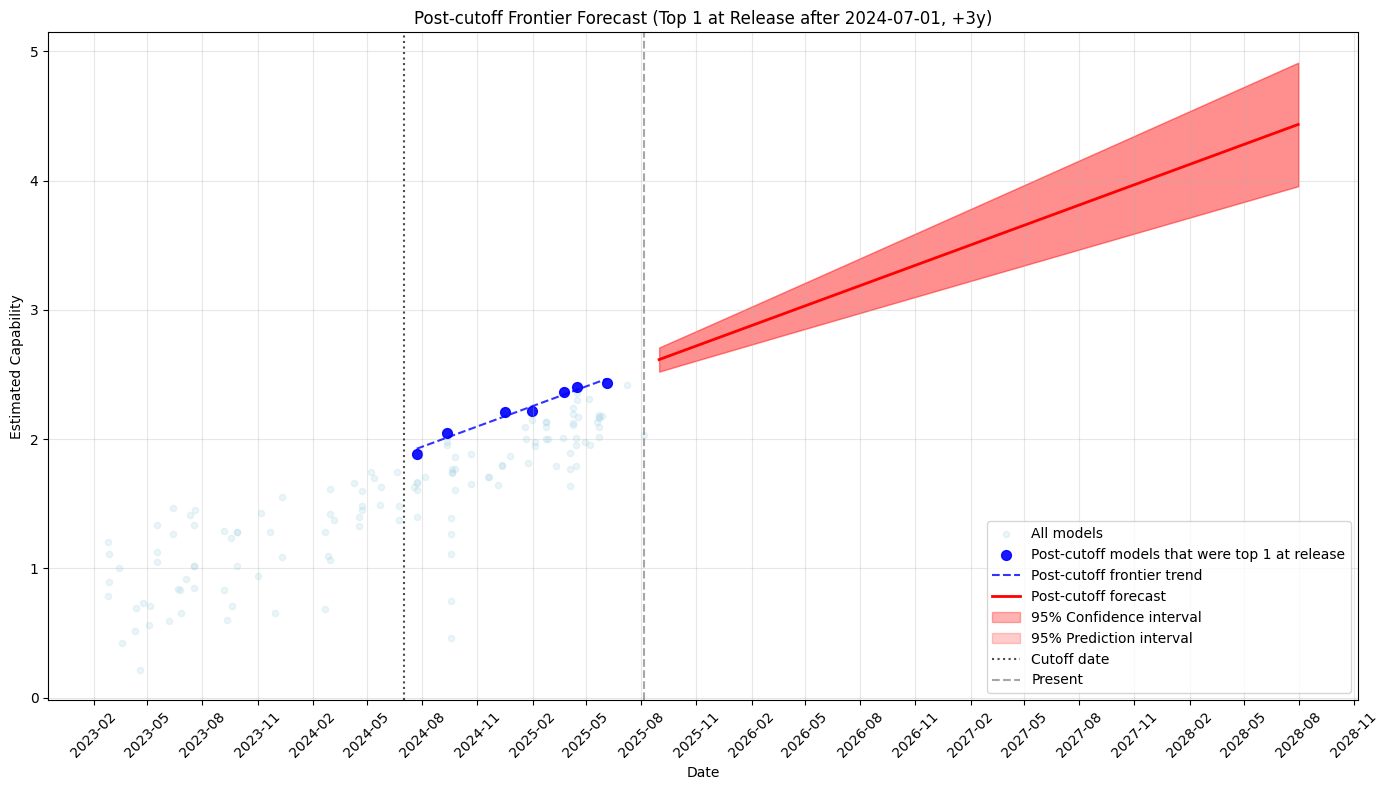

In [18]:
# Create post-cutoff frontier forecast using df_cm1 (full dataset)
post_cutoff_results = create_post_cutoff_frontier_forecast(
    df_cm1,
    cutoff_date=CUTOFF_DATE,
    forecast_years=FORECAST_YEARS,
    top_n_models=TOP_N_MODELS,
    label_frontier=LABEL_FRONTIER
)

if post_cutoff_results:
    print(f"\nPost-cutoff Frontier Forecast (after {CUTOFF_DATE}, top {TOP_N_MODELS} at release, {FORECAST_YEARS} years):")
    print(f"  Points used: {post_cutoff_results['n_points']}")
    print(f"  Annual growth rate: {post_cutoff_results['slope_per_year']:.3f}")
    print(f"  Model R²: {post_cutoff_results['r2']:.3f}")
    
    # Display forecast table
    print("\nPost-cutoff forecast table (first 12 months):")
    display(post_cutoff_results['forecast_df'].head(12))


### 4. Analyze Benchmark Saturation


### Enhanced Forecast with Structural Breaks

This section creates forecasts that consider potential breaks in the trend, particularly:
1. **Post-ChatGPT era** (starting ~March 2023, allowing time for investment to translate to progress)
2. **Reasoning models era** (starting ~September 2024 with o1 release)


In [19]:
def create_future_forecast_with_start_date(df_capabilities: pd.DataFrame,
                                           start_date: str,
                                           forecast_years: int = 3,
                                           top_n_models: int = 1,
                                           label_frontier: bool = False,
                                           title_suffix: str = ""):
    """Create forecast using only data after a specified start date"""
    print(f"Creating {forecast_years}-year forecast starting from {start_date} (top {top_n_models} at release)...")
    
    df = prepare_model_data(df_capabilities)
    start_dt = pd.to_datetime(start_date)
    
    # Filter to only include models released after start date
    df_filtered = df[df['date_obj'] >= start_dt].copy()
    
    if len(df_filtered) < 3:
        print(f"Insufficient data after {start_date} - skipping")
        return {}
    
    # Identify frontier models from the filtered dataset
    frontier_models = []
    
    for _, model in df_filtered.iterrows():
        model_release_date = model['date_obj']
        
        # For frontier detection, only consider models within the filtered date range
        available_models = df_filtered[df_filtered['date_obj'] <= model_release_date]
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            frontier_models.append(model)
    
    df_frontier = pd.DataFrame(frontier_models)
    
    if len(df_frontier) < 2:
        print(f"Insufficient frontier models after {start_date} - skipping")
        return {}
    
    print(f"Using {len(df_frontier)} frontier model data points (from {len(df_filtered)} total after {start_date})")
    
    # Prepare data for modeling
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    
    # Fit models
    model = LinearRegression()
    model.fit(X, y)
    
    X_sm = sm.add_constant(X.flatten())
    model_sm = sm.OLS(y, X_sm).fit()
    
    # Create forecast dates
    last_date = df['date_obj'].max()
    forecast_end = last_date + timedelta(days=365.25 * forecast_years)
    forecast_dates = pd.date_range(start=last_date, end=forecast_end, freq='ME')
    
    # Convert forecast dates to numeric (using same baseline as training)
    X_forecast = (forecast_dates - df_frontier['date_obj'].min()).days.values.reshape(-1, 1)
    X_forecast_sm = sm.add_constant(X_forecast.flatten())
    
    # Make predictions
    y_forecast = model.predict(X_forecast)
    
    # Get confidence and prediction intervals
    forecast_sm = model_sm.get_prediction(X_forecast_sm)
    ci_lower = forecast_sm.conf_int()[:, 0]
    ci_upper = forecast_sm.conf_int()[:, 1]
    
    try:
        pi_lower = forecast_sm.prediction_interval[:, 0]
        pi_upper = forecast_sm.prediction_interval[:, 1]
    except AttributeError:
        prediction_std_err = forecast_sm.se_mean
        t_val = stats.t.ppf(0.975, model_sm.df_resid)
        pi_lower = y_forecast - t_val * prediction_std_err
        pi_upper = y_forecast + t_val * prediction_std_err
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot all historical data (faded)
    ax.scatter(df['date_obj'], df['estimated_capability'], 
              alpha=0.2, s=20, label='All models (all time)', color='lightgray')
    
    # Highlight models after start date
    ax.scatter(df_filtered['date_obj'], df_filtered['estimated_capability'],
              alpha=0.3, s=25, label=f'All models (after {start_date})', color='lightblue')
    
    # Plot frontier models (highlighted)
    ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], 
              alpha=0.8, s=50, label=f'Frontier models (top {top_n_models} at release)', color='blue')
    
    # Optional labels
    if label_frontier:
        for _, r in df_frontier.dropna(subset=['date_obj', 'estimated_capability']).iterrows():
            ax.annotate(
                r['model'],
                xy=(r['date_obj'], r['estimated_capability']),
                xytext=(4, 4),
                textcoords='offset points',
                fontsize=8,
                color='blue',
                alpha=0.9,
            )
    
    # Plot historical trend
    y_hist_trend = model.predict(X)
    ax.plot(df_frontier['date_obj'], y_hist_trend, 'b--', alpha=0.7, label='Frontier trend')
    
    # Plot forecast
    ax.plot(forecast_dates, y_forecast, 'r-', linewidth=2, label='Forecast')
    ax.fill_between(forecast_dates, ci_lower, ci_upper, 
                   alpha=0.3, color='red', label='95% Confidence interval')
    ax.fill_between(forecast_dates, pi_lower, pi_upper, 
                   alpha=0.2, color='red', label='95% Prediction interval')
    
    # Add vertical lines for key dates
    ax.axvline(x=start_dt, color='green', linestyle=':', alpha=0.7, label=f'Start date ({start_date})')
    ax.axvline(x=last_date, color='black', linestyle=':', alpha=0.7, label='Present')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'{forecast_years}-Year Forecast {title_suffix}\n(Starting from {start_date}, Top {top_n_models} at Release)')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Create forecast table
    forecast_df = pd.DataFrame({
        'date': forecast_dates,
        'predicted_capability': y_forecast,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'pi_lower': pi_lower,
        'pi_upper': pi_upper
    })
    
    return {
        'model': model,
        'forecast_df': forecast_df,
        'slope_per_year': model.coef_[0] * 365.25,
        'r2': model.score(X, y),
        'model_summary': model_sm.summary(),
        'n_points': len(df_frontier),
        'start_date': start_date
    }


In [20]:
def validate_forecast_with_start_date(df_capabilities: pd.DataFrame,
                                     start_date: str,
                                     cutoff_date: str,
                                     top_n_models: int = 1,
                                     label_frontier: bool = False):
    """Validate forecast accuracy using only data after start_date for training"""
    print(f"Validating forecast (start: {start_date}, cutoff: {cutoff_date}, top {top_n_models})...")
    
    df = prepare_model_data(df_capabilities)
    start_dt = pd.to_datetime(start_date)
    cutoff_dt = pd.to_datetime(cutoff_date)
    
    # Filter to models after start date
    df_filtered = df[df['date_obj'] >= start_dt].copy()
    
    # Identify frontier models
    frontier_models_pre = []
    frontier_models_post = []
    
    for _, model in df_filtered.iterrows():
        model_release_date = model['date_obj']
        
        # Only consider models within the filtered date range
        available_models = df_filtered[df_filtered['date_obj'] <= model_release_date]
        top_models_at_release = available_models.nlargest(top_n_models, 'estimated_capability')
        
        if model['model'] in top_models_at_release['model'].values:
            if model_release_date <= cutoff_dt:
                frontier_models_pre.append(model)
            else:
                frontier_models_post.append(model)
    
    pre_cutoff = pd.DataFrame(frontier_models_pre)
    post_cutoff = pd.DataFrame(frontier_models_post)
    
    if len(pre_cutoff) < 2 or len(post_cutoff) == 0:
        print(f"Insufficient data for validation (pre: {len(pre_cutoff)}, post: {len(post_cutoff)})")
        return {}
    
    # Fit model on pre-cutoff data
    X_pre = (pre_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pre = pre_cutoff['estimated_capability'].values
    
    model = LinearRegression()
    model.fit(X_pre, y_pre)
    
    # Predict post-cutoff
    X_post = (post_cutoff['date_obj'] - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pred = model.predict(X_post)
    y_actual = post_cutoff['estimated_capability'].values
    
    # Calculate metrics
    mae = np.mean(np.abs(y_pred - y_actual))
    rmse = np.sqrt(np.mean((y_pred - y_actual)**2))
    r2 = 1 - np.sum((y_actual - y_pred)**2) / np.sum((y_actual - np.mean(y_actual))**2)
    
    # Create validation plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Context: all models
    pre_all = df[(df['date_obj'] >= start_dt) & (df['date_obj'] <= cutoff_dt)]
    post_all = df[(df['date_obj'] > cutoff_dt)]
    
    ax.scatter(pre_all['date_obj'], pre_all['estimated_capability'],
              alpha=0.2, s=20, label='All models (pre-cutoff)', color='lightblue')
    ax.scatter(post_all['date_obj'], post_all['estimated_capability'],
              alpha=0.2, s=20, label='All models (post-cutoff)', color='lightgreen')
    
    # Frontier models
    ax.scatter(pre_cutoff['date_obj'], pre_cutoff['estimated_capability'],
              alpha=0.8, s=50, label='Frontier (pre-cutoff)', color='blue')
    ax.scatter(post_cutoff['date_obj'], post_cutoff['estimated_capability'],
              alpha=0.8, s=50, label='Frontier (actual)', color='green')
    
    # Predictions
    ax.scatter(post_cutoff['date_obj'], y_pred,
              alpha=0.7, s=50, marker='x', label='Predicted', color='red')
    
    # Trend line
    all_dates = pd.concat([pre_cutoff['date_obj'], post_cutoff['date_obj']])
    X_all = (all_dates - pre_cutoff['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_trend = model.predict(X_all)
    ax.plot(all_dates, y_trend, 'r--', alpha=0.7, label='Trend line')
    
    # Key dates
    ax.axvline(x=start_dt, color='green', linestyle=':', alpha=0.7, label=f'Start ({start_date})')
    ax.axvline(x=cutoff_dt, color='black', linestyle=':', alpha=0.7, label=f'Cutoff ({cutoff_date})')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Forecast Validation (Start: {start_date}, Cutoff: {cutoff_date}, Top {top_n_models})')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'n_training': len(pre_cutoff),
        'n_validation': len(post_cutoff),
        'slope': model.coef_[0] * 365.25,
        'intercept': model.intercept_,
        'start_date': start_date
    }


### Compare Forecasts Across Different Start Dates


Comparing forecast validation across different start dates:

All data (2020+) (starting 2020-01-01):
Validating forecast (start: 2020-01-01, cutoff: 2024-07-01, top 1)...
  MAE: 0.247
  RMSE: 0.259
  R²: -0.930
  Slope (per year): 0.380
  Training points: 7
  Validation points: 7

Recent era (2022+) (starting 2022-01-01):
Validating forecast (start: 2022-01-01, cutoff: 2024-07-01, top 1)...
  MAE: 0.247
  RMSE: 0.259
  R²: -0.930
  Slope (per year): 0.380
  Training points: 7
  Validation points: 7

Post-ChatGPT (2023-03+) (starting 2022-11-01):
Validating forecast (start: 2022-11-01, cutoff: 2024-07-01, top 1)...
  MAE: 0.247
  RMSE: 0.259
  R²: -0.930
  Slope (per year): 0.380
  Training points: 7
  Validation points: 7

Reasoning era (2024-09+) (starting 2024-09-01):
Validating forecast (start: 2024-09-01, cutoff: 2024-07-01, top 1)...
Insufficient data for validation (pre: 0, post: 6)

VALIDATION COMPARISON SUMMARY


,label,mae,rmse,r2,slope,n_training,n_validation
0,All data (2020+),0.246613,0.259073,-0.930043,0.380322,7,7
1,Recent era (2022+),0.246613,0.259073,-0.930043,0.380322,7,7
2,Post-ChatGPT (2023-03+),0.246613,0.259073,-0.930043,0.380322,7,7


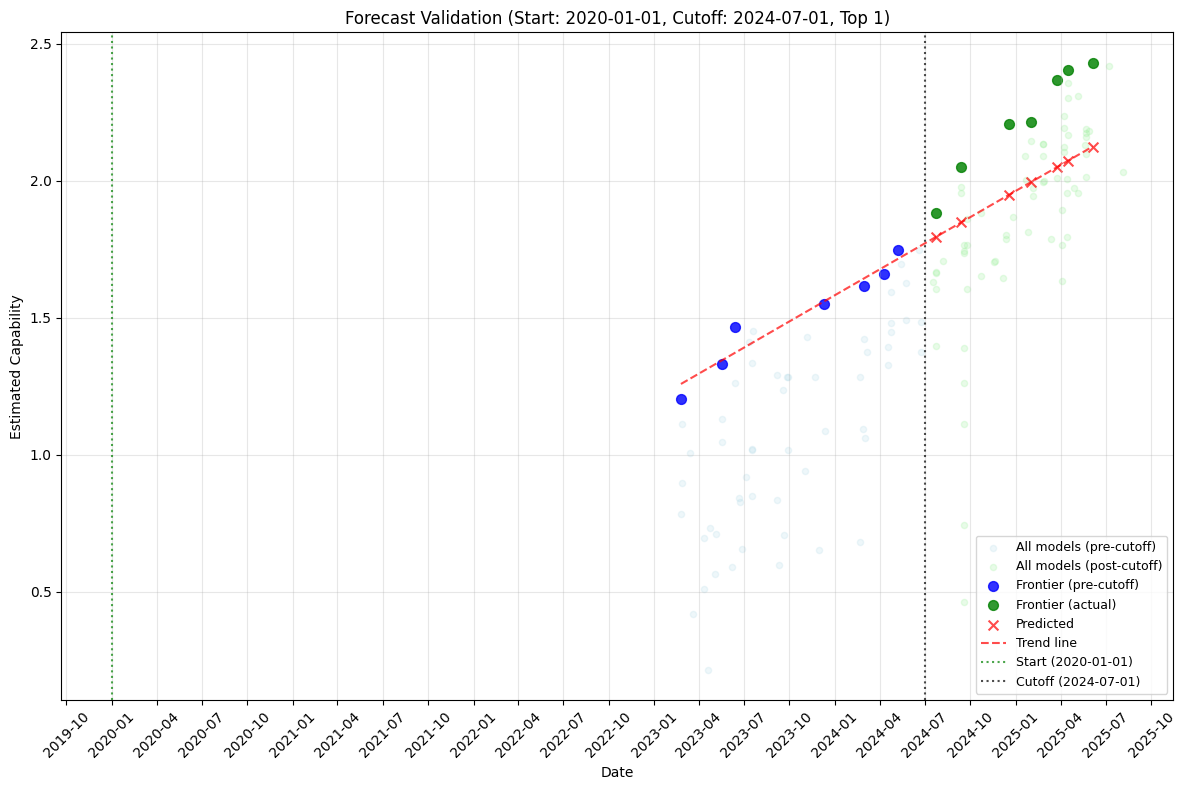

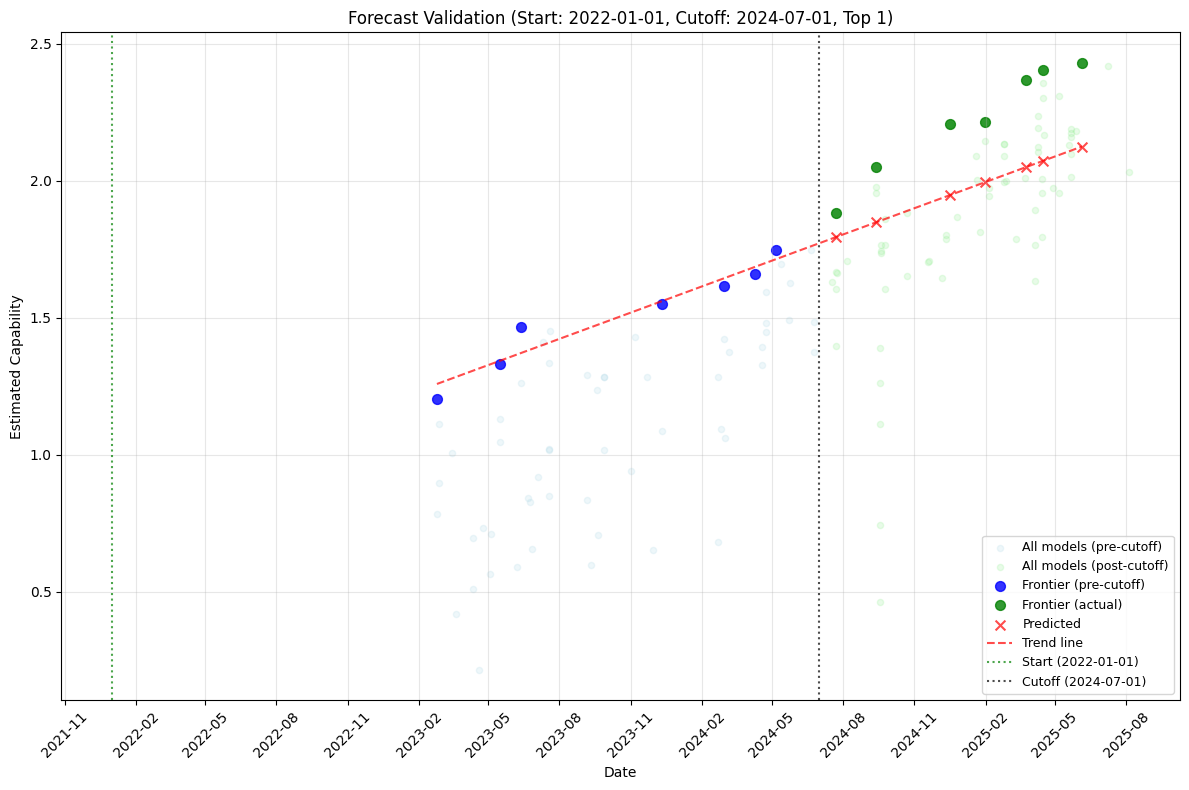

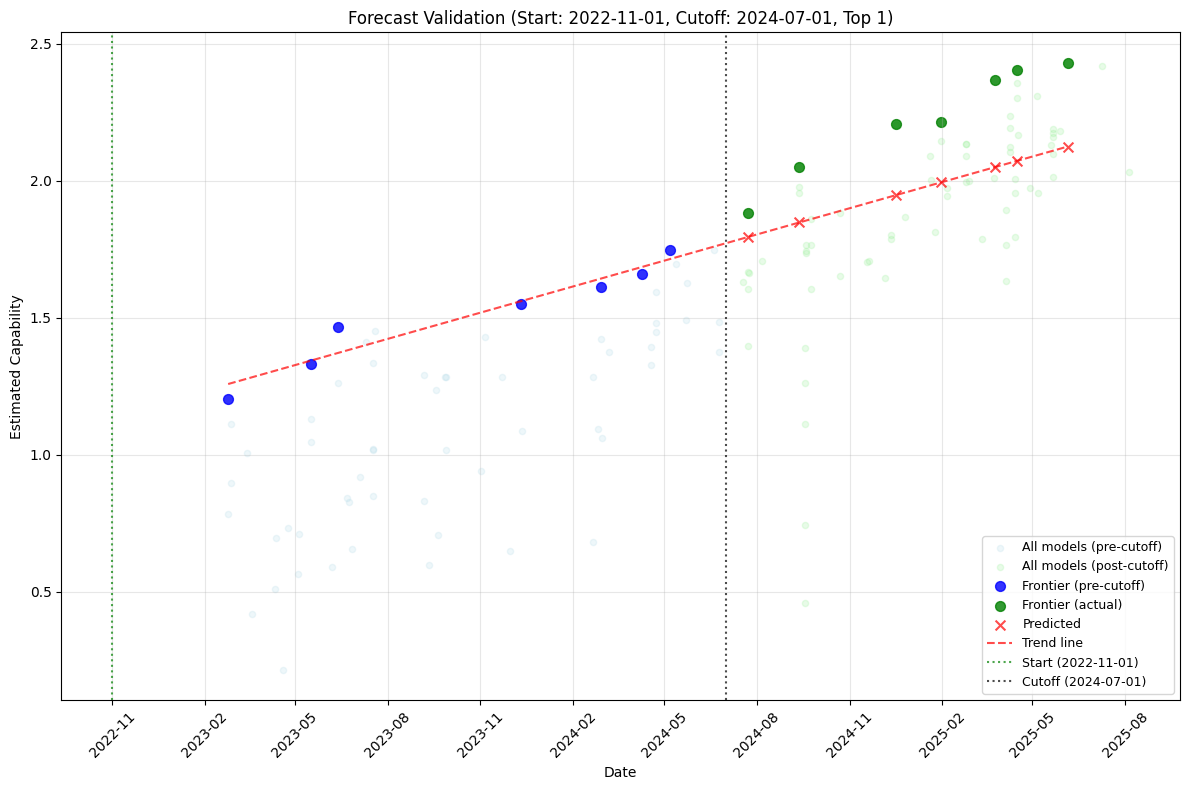

In [31]:
# Key dates to consider
# ChatGPT was released Nov 30, 2022
# Allow ~3 months for investment to translate to progress
CHATGPT_START = '2022-11-01'  # Post-ChatGPT era
REASONING_START = '2024-09-01'  # Reasoning models era (o1 released Sep 2024)

# Compare validation performance across different start dates
start_dates_to_compare = [
    ('2020-01-01', 'All data (2020+)'),
    ('2022-01-01', 'Recent era (2022+)'),
    (CHATGPT_START, 'Post-ChatGPT (2023-03+)'),
    (REASONING_START, 'Reasoning era (2024-09+)')
]

validation_comparison = []

print("Comparing forecast validation across different start dates:")
print("=" * 80)

for start_date, label in start_dates_to_compare:
    print(f"\n{label} (starting {start_date}):")
    result = validate_forecast_with_start_date(
        df_cm1,
        start_date=start_date,
        cutoff_date=CUTOFF_DATE,
        top_n_models=TOP_N_MODELS,
        label_frontier=False
    )
    
    if result:
        print(f"  MAE: {result['mae']:.3f}")
        print(f"  RMSE: {result['rmse']:.3f}")
        print(f"  R²: {result['r2']:.3f}")
        print(f"  Slope (per year): {result['slope']:.3f}")
        print(f"  Training points: {result['n_training']}")
        print(f"  Validation points: {result['n_validation']}")
        
        validation_comparison.append({
            'start_date': start_date,
            'label': label,
            **result
        })

# Summary table
if validation_comparison:
    print("\n" + "=" * 80)
    print("VALIDATION COMPARISON SUMMARY")
    print("=" * 80)
    comparison_df = pd.DataFrame(validation_comparison)
    display(comparison_df[['label', 'mae', 'rmse', 'r2', 'slope', 'n_training', 'n_validation']])


### Create Forecasts with Structural Break Consideration


Creating Post-ChatGPT Forecast:
Creating 3-year forecast starting from 2023-03-01 (top 1 at release)...
Using 14 frontier model data points (from 132 total after 2023-03-01)

Post-ChatGPT Forecast Results:
  Annual growth rate: 0.586
  Model R²: 0.963
  Points used: 14

Forecast table (first 12 months):


,date,predicted_capability,ci_lower,ci_upper,pi_lower,pi_upper
0,2025-08-31,2.577392,2.474600,2.680185,2.474600,2.680185
1,2025-09-30,2.625543,2.517584,2.733502,2.517584,2.733502
2,2025-10-31,2.675299,2.561925,2.788673,2.561925,2.788673
3,2025-11-30,2.723450,2.604771,2.842130,2.604771,2.842130
4,2025-12-31,2.773206,2.648987,2.897426,2.648987,2.897426
5,2026-01-31,2.822962,2.693151,2.952773,2.693151,2.952773
6,2026-02-28,2.867903,2.733003,3.002803,2.733003,3.002803
7,2026-03-31,2.917659,2.777087,3.058232,2.777087,3.058232
8,2026-04-30,2.965810,2.819714,3.111906,2.819714,3.111906
9,2026-05-31,3.015566,2.863732,3.167401,2.863732,3.167401


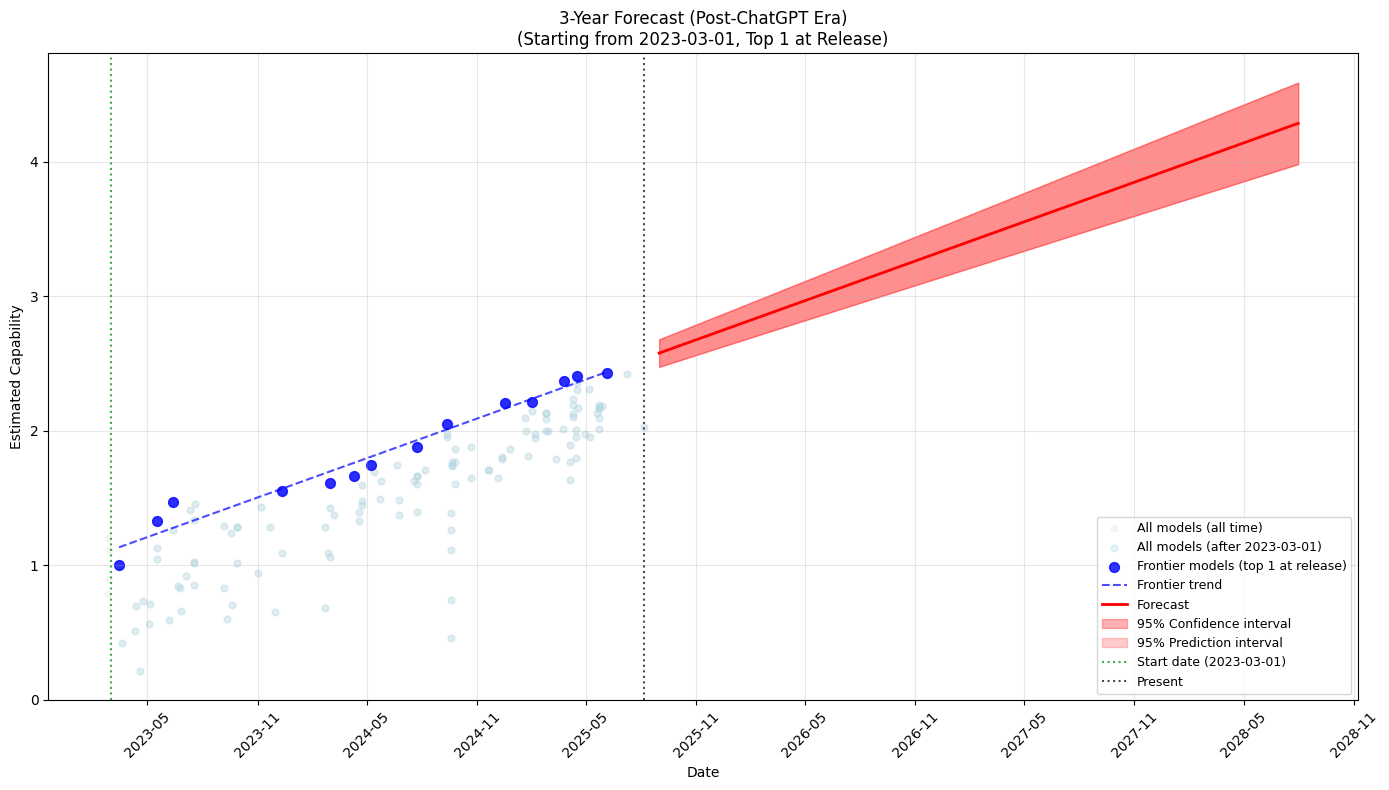

In [22]:
# Create forecast using Post-ChatGPT data
print("Creating Post-ChatGPT Forecast:")
print("=" * 80)
chatgpt_forecast = create_future_forecast_with_start_date(
    df_cm1,
    start_date=CHATGPT_START,
    forecast_years=FORECAST_YEARS,
    top_n_models=TOP_N_MODELS,
    label_frontier=LABEL_FRONTIER,
    title_suffix="(Post-ChatGPT Era)"
)

if chatgpt_forecast:
    print(f"\nPost-ChatGPT Forecast Results:")
    print(f"  Annual growth rate: {chatgpt_forecast['slope_per_year']:.3f}")
    print(f"  Model R²: {chatgpt_forecast['r2']:.3f}")
    print(f"  Points used: {chatgpt_forecast['n_points']}")
    print("\nForecast table (first 12 months):")
    display(chatgpt_forecast['forecast_df'].head(12))



Creating Reasoning Models Era Forecast:
Creating 3-year forecast starting from 2024-09-01 (top 1 at release)...
Using 6 frontier model data points (from 67 total after 2024-09-01)

Reasoning Models Era Forecast Results:
  Annual growth rate: 0.554
  Model R²: 0.959
  Points used: 6

Forecast table (first 12 months):


/Users/ansonho/Documents/github/benchmark-stitching/benchmark_stitching_env/lib/python3.13/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


,date,predicted_capability,ci_lower,ci_upper,pi_lower,pi_upper
0,2025-08-31,2.583704,2.488116,2.679292,2.488116,2.679292
1,2025-09-30,2.629205,2.521460,2.736949,2.521460,2.736949
2,2025-10-31,2.676222,2.555707,2.796738,2.555707,2.796738
3,2025-11-30,2.721723,2.588703,2.854743,2.588703,2.854743
4,2025-12-31,2.768741,2.622688,2.914793,2.622688,2.914793
5,2026-01-31,2.815758,2.656588,2.974929,2.656588,2.974929
6,2026-02-28,2.858226,2.687150,3.029302,2.687150,3.029302
7,2026-03-31,2.905243,2.720936,3.089550,2.720936,3.089550
8,2026-04-30,2.950744,2.753593,3.147896,2.753593,3.147896
9,2026-05-31,2.997762,2.787303,3.208220,2.787303,3.208220


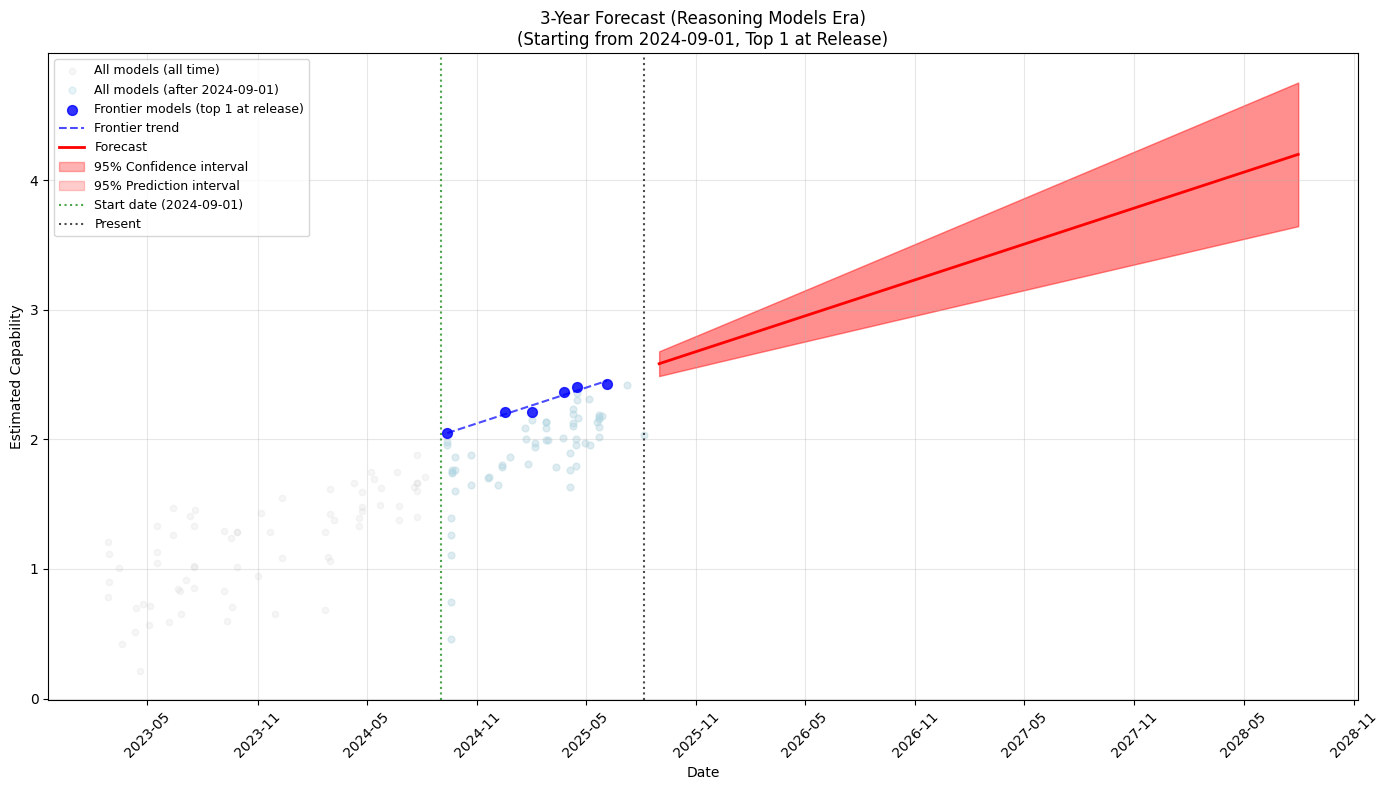

In [23]:
# Create forecast using Reasoning Models era data  
print("\nCreating Reasoning Models Era Forecast:")
print("=" * 80)
reasoning_forecast = create_future_forecast_with_start_date(
    df_cm1,
    start_date=REASONING_START,
    forecast_years=FORECAST_YEARS,
    top_n_models=TOP_N_MODELS,
    label_frontier=LABEL_FRONTIER,
    title_suffix="(Reasoning Models Era)"
)

if reasoning_forecast:
    print(f"\nReasoning Models Era Forecast Results:")
    print(f"  Annual growth rate: {reasoning_forecast['slope_per_year']:.3f}")
    print(f"  Model R²: {reasoning_forecast['r2']:.3f}")
    print(f"  Points used: {reasoning_forecast['n_points']}")
    print("\nForecast table (first 12 months):")
    display(reasoning_forecast['forecast_df'].head(12))


### Compare Growth Rates Across Different Eras


---
## Acceleration Detection

Apply the piecewise linear breakpoint detection approach to identify potential acceleration in AI capabilities.

### Piecewise Linear Breakpoint Detection

This approach (from `software_singularity.ipynb`) fits a piecewise linear model to capability data to detect acceleration points.


In [24]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def piecewise_linear(x, slope1, intercept1, slope2, breakpoint):
    """Piecewise linear function with continuity at breakpoint"""
    intercept2 = slope1 * breakpoint + intercept1 - slope2 * breakpoint
    return np.where(x < breakpoint, slope1*x + intercept1, slope2*x + intercept2)

def fit_piecewise_linear(x, y, num_breaks=30):
    """Fit a piecewise linear model by scanning candidate breakpoints"""
    best = (-np.inf, None)
    xs, ys = x, y
    rng = xs.max() - xs.min()
    min_bp = xs.min() + 0.1 * rng
    max_bp = xs.max() - 0.1 * rng
    lower = [-np.inf, -np.inf, -np.inf, min_bp]
    upper = [ np.inf,  np.inf,  np.inf, max_bp]

    for bp in np.linspace(min_bp, max_bp, num_breaks):
        left = xs <= bp
        right = xs > bp
        if left.sum() < 2 or right.sum() < 2:
            continue

        # Initial guesses
        m1, b1 = np.polyfit(xs[left], ys[left], 1)
        m2, _  = np.polyfit(xs[right], ys[right], 1)
        i1 = np.mean(ys[left]) - m1 * np.mean(xs[left])
        p0 = [m1, i1, m2, bp]

        try:
            params, _ = curve_fit(
                piecewise_linear,
                xs, ys,
                p0=p0,
                bounds=(lower, upper),
                maxfev=2000
            )
            r2 = r2_score(ys, piecewise_linear(xs, *params))
            if r2 > best[0]:
                best = (r2, params)
        except Exception:
            pass

    return best[1], best[0]

def detect_acceleration_frontier(df_capabilities: pd.DataFrame, 
                                 num_breaks: int = 50,
                                 min_slope_ratio: float = 1.5):
    """
    Detect acceleration in frontier model capabilities using piecewise linear fitting.
    
    Args:
        df_capabilities: DataFrame with 'date' and 'estimated_capability' columns
        num_breaks: Number of candidate breakpoints to try
        min_slope_ratio: Minimum slope ratio to consider as acceleration
    
    Returns:
        Dictionary with detection results
    """
    df = prepare_model_data(df_capabilities)
    
    # Compute running maximum (frontier)
    df = df.sort_values('date_obj')
    df['running_max'] = df['estimated_capability'].cummax()
    
    # Get frontier models (those that set new records)
    frontier_df = df[df['estimated_capability'] == df['running_max']].copy()
    
    if len(frontier_df) < 10:
        print("Insufficient frontier data points for acceleration detection")
        return {}
    
    # Convert dates to years (numeric)
    x = mdates.date2num(frontier_df['date_obj'].values)
    y = frontier_df['estimated_capability'].values
    
    # Fit piecewise linear model
    params, r2 = fit_piecewise_linear(x, y, num_breaks=num_breaks)
    
    if params is None:
        print("Failed to fit piecewise linear model")
        return {}
    
    slope1, intercept1, slope2, bp = params
    
    # Convert breakpoint back to date (remove timezone to avoid comparison issues)
    breakpoint_date = mdates.num2date(bp).replace(tzinfo=None)
    
    # Calculate slope ratio
    slope_ratio = slope2 / slope1 if slope1 > 0 else np.inf
    
    # Check if acceleration detected
    acceleration_detected = slope_ratio >= min_slope_ratio
    
    # Visualize
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # All models (faded)
    ax.scatter(df['date_obj'], df['estimated_capability'],
              alpha=0.2, s=20, label='All models', color='lightgray')
    
    # Frontier models
    ax.scatter(frontier_df['date_obj'], frontier_df['estimated_capability'],
              s=50, label='Frontier (running max)', color='blue', alpha=0.8)
    
    # Piecewise fit
    x_fine = np.linspace(x.min(), x.max(), 400)
    y_fine = piecewise_linear(x_fine, *params)
    dates_fine = [mdates.num2date(d).replace(tzinfo=None) for d in x_fine]
    ax.plot(dates_fine, y_fine, 'r--', linewidth=2, label='Piecewise linear fit')
    
    # Breakpoint line
    ax.axvline(x=breakpoint_date, color='orange', linestyle=':', linewidth=2, 
              label=f'Breakpoint: {breakpoint_date.strftime("%Y-%m-%d")}')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Estimated Capability')
    ax.set_title(f'Frontier Acceleration Detection\n' +
                f'Pre-break slope: {slope1*365.25:.3f}/year, Post-break slope: {slope2*365.25:.3f}/year, ' +
                f'Ratio: {slope_ratio:.2f}x (R²={r2:.4f})')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return {
        'breakpoint_date': breakpoint_date,
        'slope_pre': slope1,
        'slope_post': slope2,
        'slope_pre_per_year': slope1 * 365.25,
        'slope_post_per_year': slope2 * 365.25,
        'slope_ratio': slope_ratio,
        'r2': r2,
        'acceleration_detected': acceleration_detected,
        'frontier_df': frontier_df,
        'params': params
    }


### Run Acceleration Detection on Real Data


Running acceleration detection on frontier models...

ACCELERATION DETECTION RESULTS
Breakpoint detected at: 2024-03-17
Pre-break slope: 0.370 capability units/year
Post-break slope: 0.682 capability units/year
Slope ratio: 1.85x
Model fit (R²): 0.9900
Acceleration detected: True

Comparison to known events:
  Days from ChatGPT release: 473 days
  Days from o1 release: -179 days

Frontier models around breakpoint (±6 months):


,model,date,estimated_capability
139,Mixtral-8x7B-v0.1,2023-12-11,1.550895
83,claude-3-opus-20240229,2024-02-29,1.614018
92,gpt-4-turbo-2024-04-09,2024-04-09,1.659871
27,DeepSeek-V2,2024-05-07,1.747366
29,Llama-3.1-405B,2024-07-23,1.882331
94,o1-mini-2024-09-12_medium,2024-09-12,1.976792
87,o1-mini-2024-09-12_high,2024-09-12,2.049852


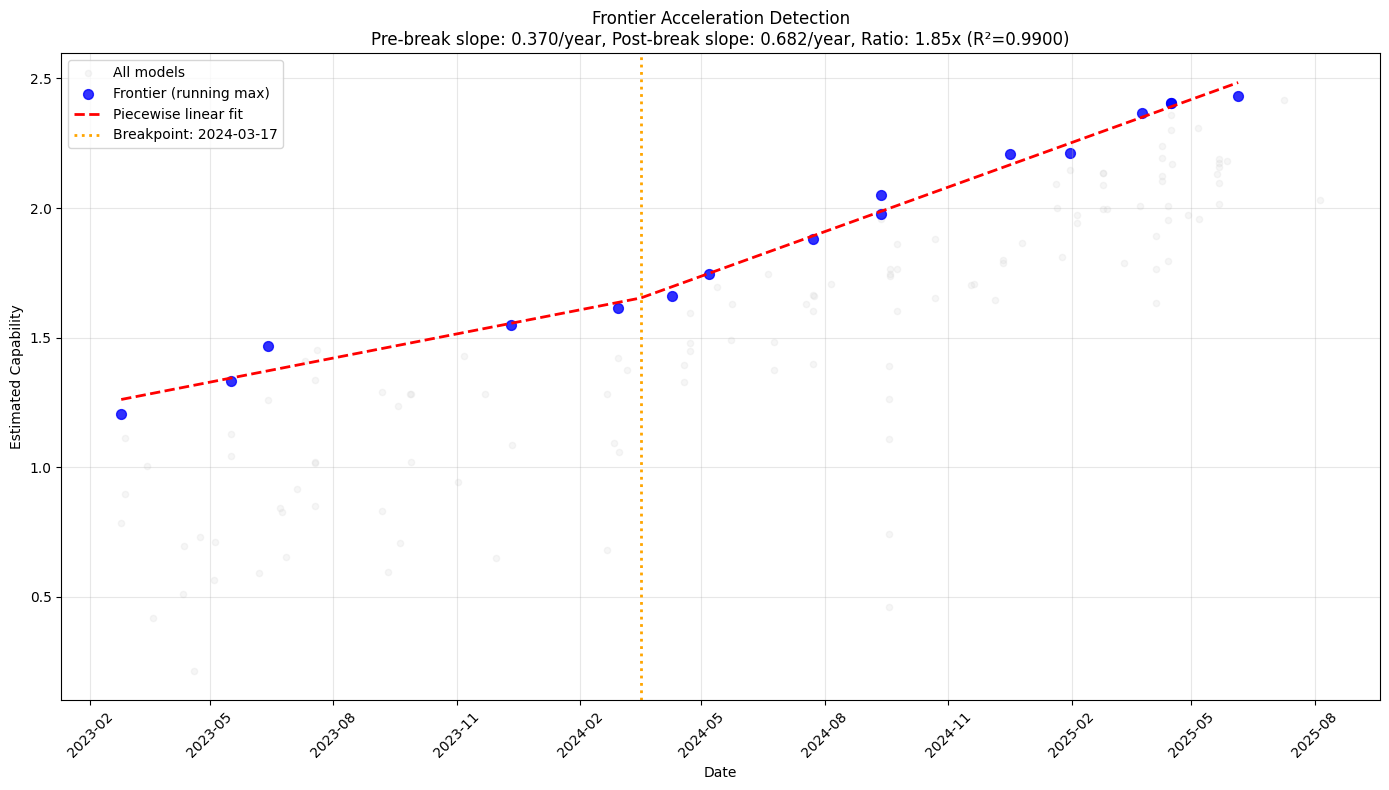

In [25]:
# Run acceleration detection on full dataset (df_cm1)
print("Running acceleration detection on frontier models...")
print("=" * 80)

accel_results = detect_acceleration_frontier(
    df_cm1,
    num_breaks=50,
    min_slope_ratio=1.5  # Detect if post-break is 1.5x faster than pre-break
)

if accel_results:
    print("\nACCELERATION DETECTION RESULTS")
    print("=" * 80)
    print(f"Breakpoint detected at: {accel_results['breakpoint_date'].strftime('%Y-%m-%d')}")
    print(f"Pre-break slope: {accel_results['slope_pre_per_year']:.3f} capability units/year")
    print(f"Post-break slope: {accel_results['slope_post_per_year']:.3f} capability units/year")
    print(f"Slope ratio: {accel_results['slope_ratio']:.2f}x")
    print(f"Model fit (R²): {accel_results['r2']:.4f}")
    print(f"Acceleration detected: {accel_results['acceleration_detected']}")
    
    # Compare to known events
    breakpoint = accel_results['breakpoint_date']
    chatgpt_date = pd.Timestamp('2022-11-30')
    o1_date = pd.Timestamp('2024-09-12')
    
    print(f"\nComparison to known events:")
    print(f"  Days from ChatGPT release: {(breakpoint - chatgpt_date).days} days")
    print(f"  Days from o1 release: {(breakpoint - o1_date).days} days")
    
    # Show frontier models around the breakpoint
    frontier_df = accel_results['frontier_df']
    bp_date = accel_results['breakpoint_date']
    window = pd.Timedelta(days=180)  # 6 months
    
    around_bp = frontier_df[
        (frontier_df['date_obj'] >= bp_date - window) &
        (frontier_df['date_obj'] <= bp_date + window)
    ][['model', 'date', 'estimated_capability']].sort_values('date')
    
    if len(around_bp) > 0:
        print(f"\nFrontier models around breakpoint (±6 months):")
        display(around_bp)


### Test Different Acceleration Thresholds



SENSITIVITY TO ACCELERATION THRESHOLD


,threshold,detected,breakpoint,slope_ratio,r2
0,1.2,True,2024-03-17 02:58:06.870118,1.845723,0.990017
1,1.5,True,2024-03-17 02:58:06.870118,1.845723,0.990017
2,2.0,False,2024-03-17 02:58:06.870118,1.845723,0.990017
3,2.5,False,2024-03-17 02:58:06.870118,1.845723,0.990017
4,3.0,False,2024-03-17 02:58:06.870118,1.845723,0.990017


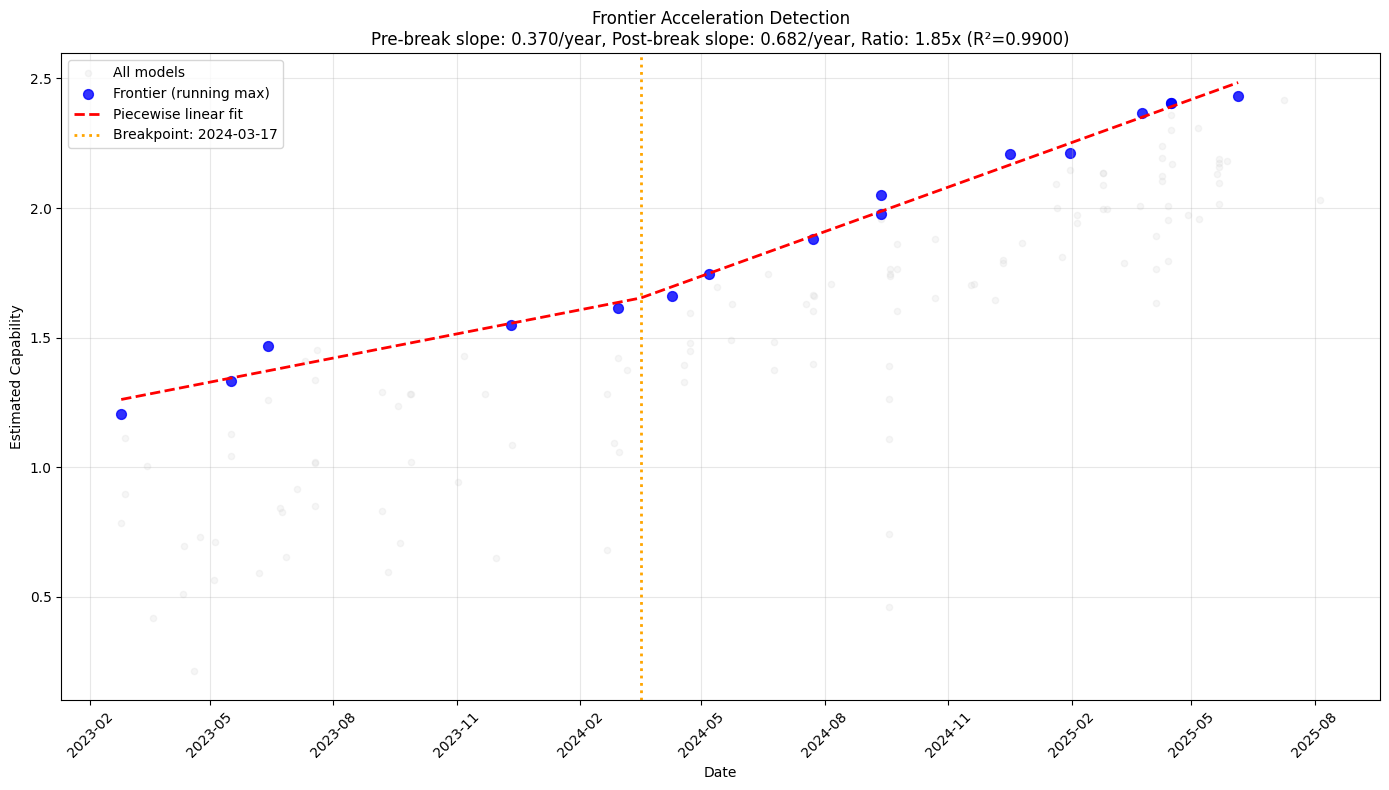

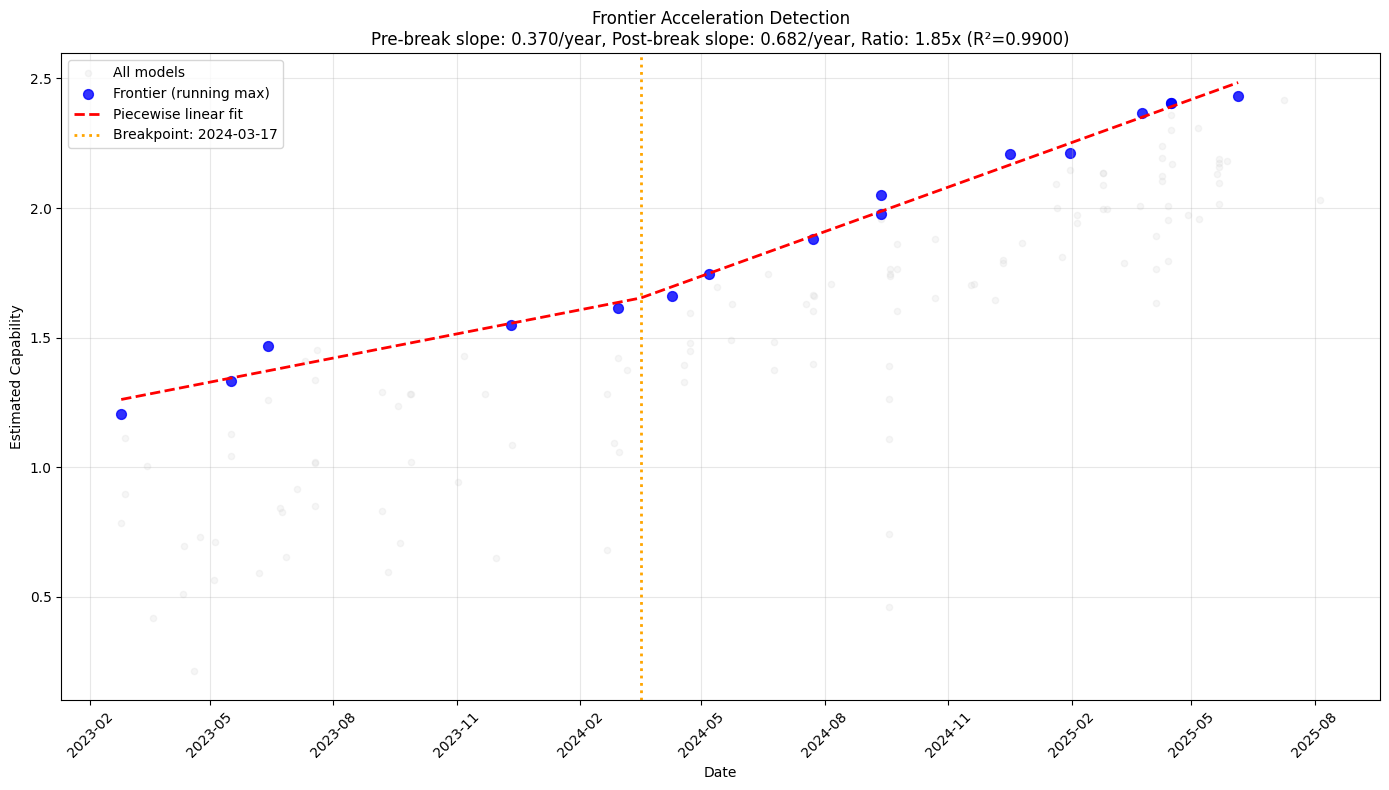

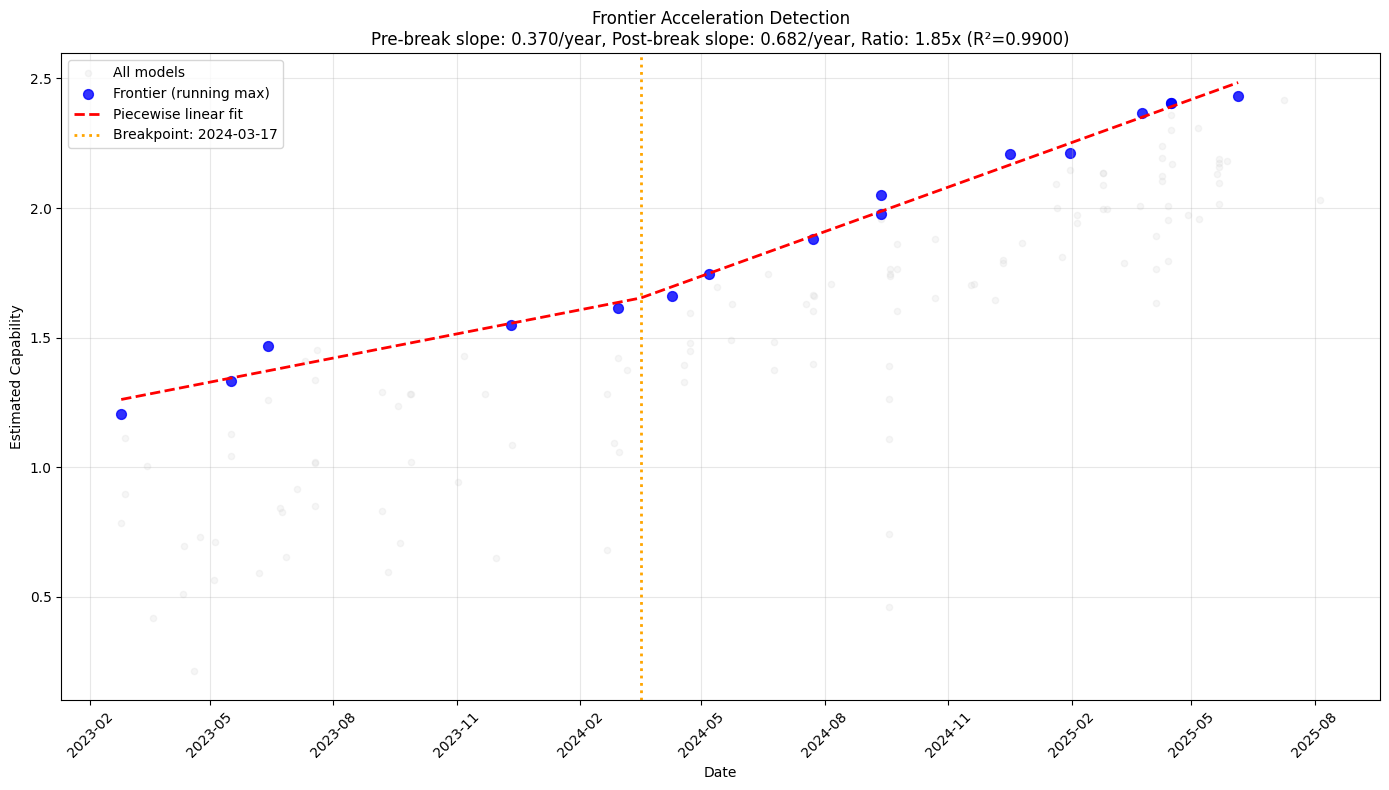

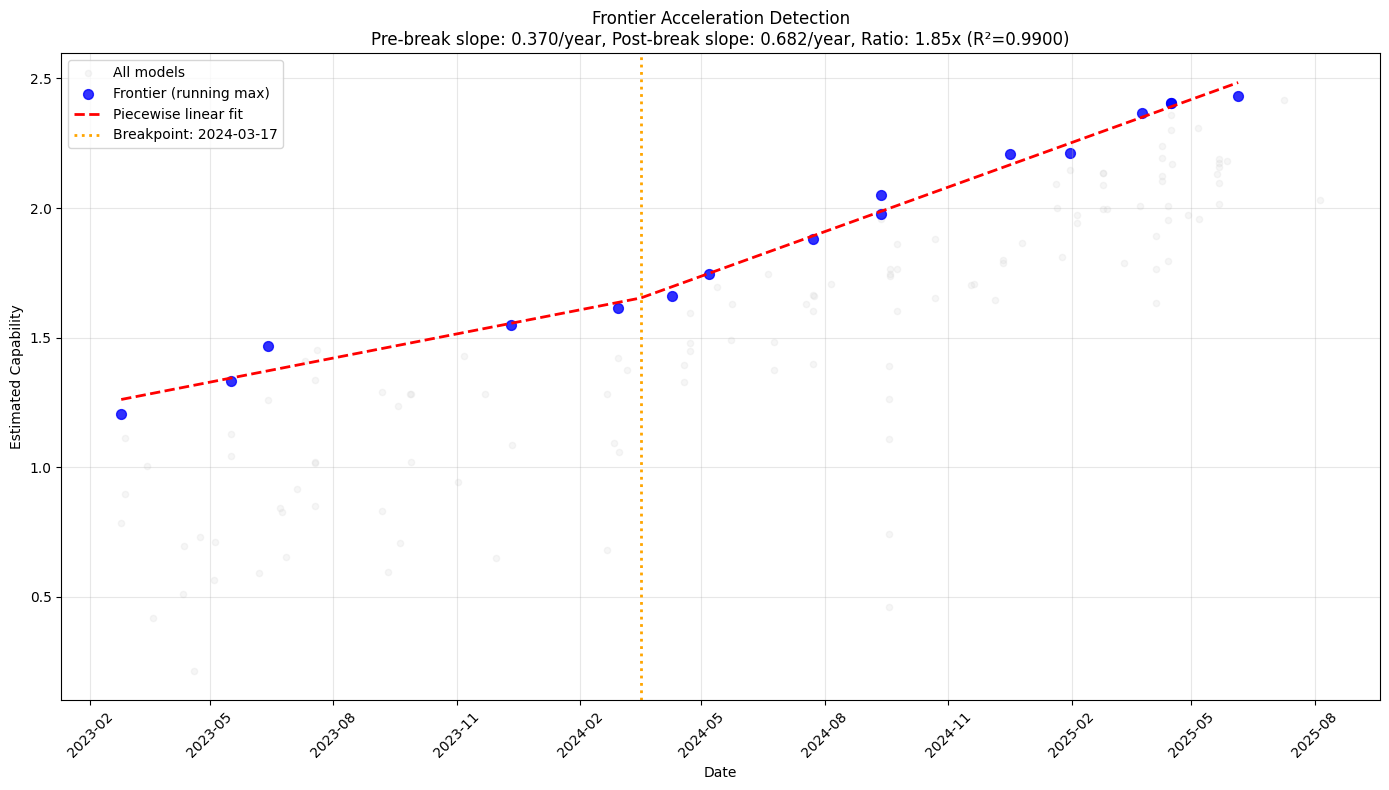

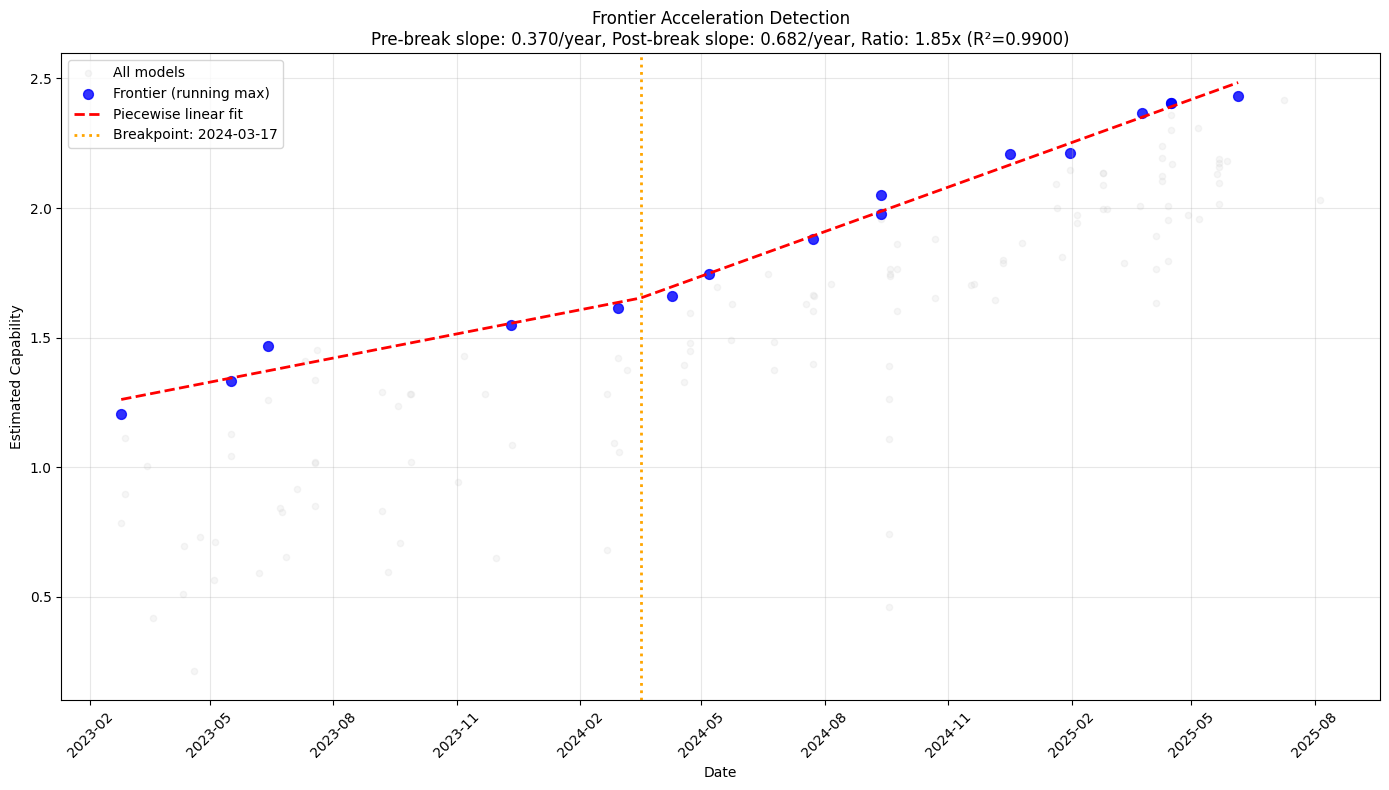

In [26]:
# Test different thresholds to see sensitivity
thresholds = [1.2, 1.5, 2.0, 2.5, 3.0]

threshold_results = []
for threshold in thresholds:
    result = detect_acceleration_frontier(df_cm1, num_breaks=50, min_slope_ratio=threshold)
    if result:
        threshold_results.append({
            'threshold': threshold,
            'detected': result['acceleration_detected'],
            'breakpoint': result['breakpoint_date'],
            'slope_ratio': result['slope_ratio'],
            'r2': result['r2']
        })
        
if threshold_results:
    print("\n" + "=" * 80)
    print("SENSITIVITY TO ACCELERATION THRESHOLD")
    print("=" * 80)
    threshold_df = pd.DataFrame(threshold_results)
    display(threshold_df)


### Compare Detection on Different Datasets

Let's also test the acceleration detection on the pre-cutoff dataset (df_cm2) to see if it detects earlier patterns.



Running acceleration detection on pre-cutoff dataset (df_cm2)...

PRE-CUTOFF ACCELERATION DETECTION RESULTS
Breakpoint detected at: 2022-03-15
Pre-break slope: 0.434 capability units/year
Post-break slope: 0.262 capability units/year
Slope ratio: 0.60x
Model fit (R²): 0.9184
Acceleration detected: False


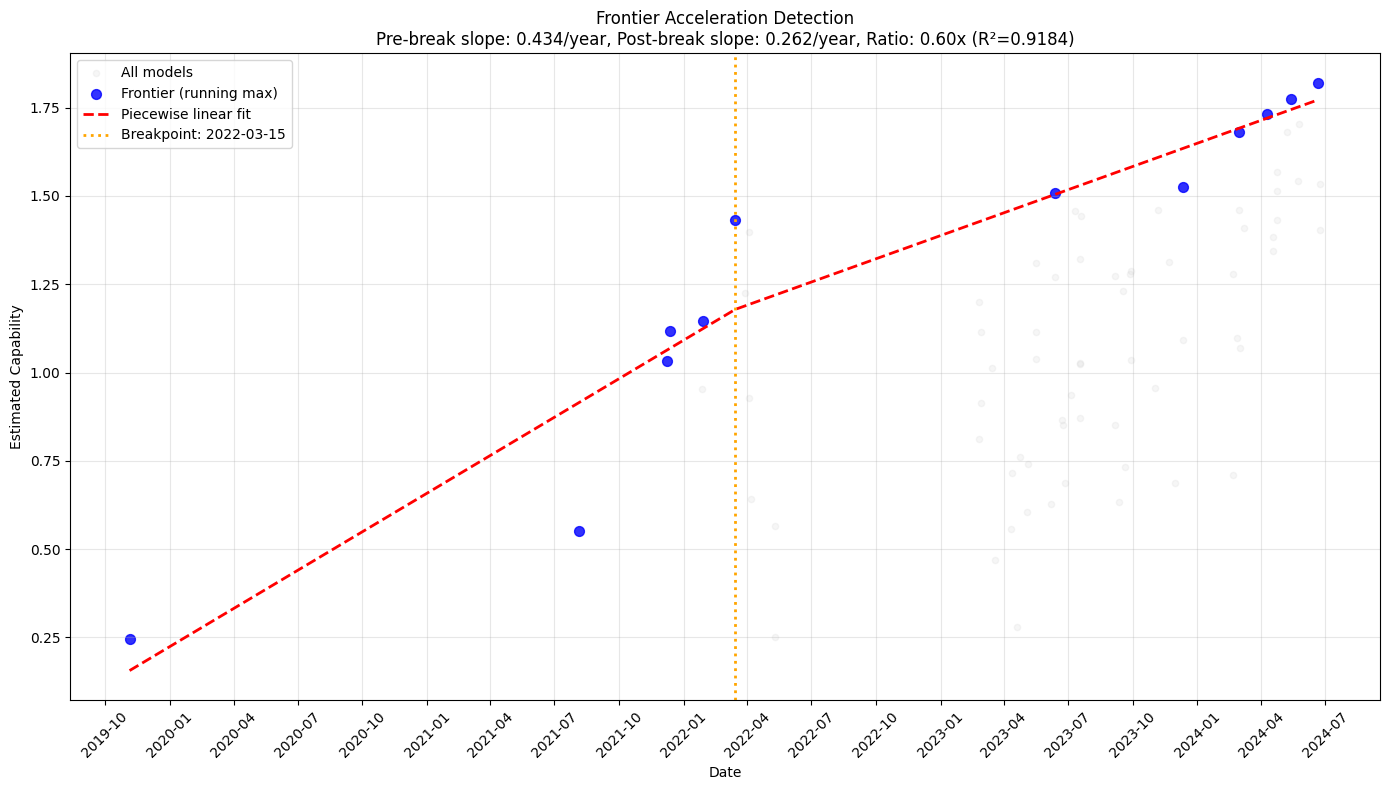

In [27]:
# Run on pre-cutoff dataset
print("\nRunning acceleration detection on pre-cutoff dataset (df_cm2)...")
print("=" * 80)

accel_results_pre = detect_acceleration_frontier(
    df_cm2,
    num_breaks=30,  # Fewer breaks since less data
    min_slope_ratio=1.5
)

if accel_results_pre:
    print("\nPRE-CUTOFF ACCELERATION DETECTION RESULTS")
    print("=" * 80)
    print(f"Breakpoint detected at: {accel_results_pre['breakpoint_date'].strftime('%Y-%m-%d')}")
    print(f"Pre-break slope: {accel_results_pre['slope_pre_per_year']:.3f} capability units/year")
    print(f"Post-break slope: {accel_results_pre['slope_post_per_year']:.3f} capability units/year")
    print(f"Slope ratio: {accel_results_pre['slope_ratio']:.2f}x")
    print(f"Model fit (R²): {accel_results_pre['r2']:.4f}")
    print(f"Acceleration detected: {accel_results_pre['acceleration_detected']}")


### Summary: Acceleration Detection vs Structural Break Analysis

Compare the automated breakpoint detection with our manual structural break analysis.


In [28]:
# Summary comparison
print("\n" + "=" * 80)
print("SUMMARY: AUTOMATED DETECTION vs MANUAL ANALYSIS")
print("=" * 80)

summary_data = []

# Automated detection
if accel_results:
    summary_data.append({
        'Method': 'Automated Piecewise Detection',
        'Breakpoint': accel_results['breakpoint_date'].strftime('%Y-%m-%d'),
        'Growth Rate (pre)': f"{accel_results['slope_pre_per_year']:.3f}",
        'Growth Rate (post)': f"{accel_results['slope_post_per_year']:.3f}",
        'Acceleration': f"{accel_results['slope_ratio']:.2f}x"
    })

# Manual structural breaks
if 'chatgpt_forecast' in locals() and chatgpt_forecast:
    summary_data.append({
        'Method': 'Post-ChatGPT (manual)',
        'Breakpoint': CHATGPT_START,
        'Growth Rate (pre)': 'N/A',
        'Growth Rate (post)': f"{chatgpt_forecast['slope_per_year']:.3f}",
        'Acceleration': 'N/A'
    })

if 'reasoning_forecast' in locals() and reasoning_forecast:
    summary_data.append({
        'Method': 'Reasoning Models (manual)',
        'Breakpoint': REASONING_START,
        'Growth Rate (pre)': 'N/A',
        'Growth Rate (post)': f"{reasoning_forecast['slope_per_year']:.3f}",
        'Acceleration': 'N/A'
    })

# Baseline
if 'forecast_results' in locals() and forecast_results:
    summary_data.append({
        'Method': 'Baseline (all time)',
        'Breakpoint': 'None',
        'Growth Rate (pre)': 'N/A',
        'Growth Rate (post)': f"{forecast_results['slope_per_year']:.3f}",
        'Acceleration': '1.00x'
    })

if summary_data:
    summary_comparison = pd.DataFrame(summary_data)
    display(summary_comparison)
    
    print("\nKey Insights:")
    print("- Automated detection identifies the data-driven breakpoint")
    print("- Manual analysis tests specific hypotheses (ChatGPT, o1 release)")
    print("- Compare growth rates to assess which structural break is most impactful")



SUMMARY: AUTOMATED DETECTION vs MANUAL ANALYSIS


,Method,Breakpoint,Growth Rate (pre),Growth Rate (post),Acceleration
0,Automated Piecewise Detection,2024-03-17,0.370,0.682,1.85x
1,Post-ChatGPT (manual),2023-03-01,N/A,0.586,N/A
2,Reasoning Models (manual),2024-09-01,N/A,0.554,N/A
3,Baseline (all time),None,N/A,0.546,1.00x



Key Insights:
- Automated detection identifies the data-driven breakpoint
- Manual analysis tests specific hypotheses (ChatGPT, o1 release)
- Compare growth rates to assess which structural break is most impactful



GROWTH RATE COMPARISON ACROSS ERAS


,Era,Start Date,Growth Rate (per year),R²,N Points
0,All time (baseline),All data,0.546460,0.967738,136
1,Post-ChatGPT,2023-03-01,0.586238,0.963250,14
2,Reasoning Models,2024-09-01,0.553973,0.958722,6


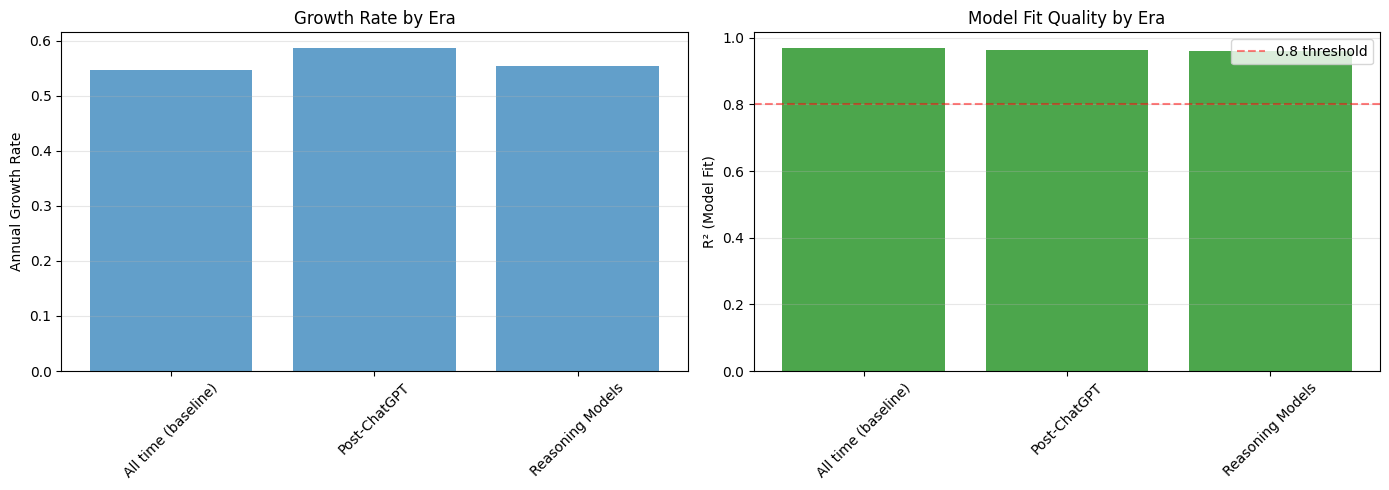


Key Insights:
  Post-ChatGPT: +7.3% change vs baseline
  Reasoning Models: +1.4% change vs baseline


In [29]:
# Compare growth rates across different eras
print("\n" + "=" * 80)
print("GROWTH RATE COMPARISON ACROSS ERAS")
print("=" * 80)

era_comparison = []

# Collect results from different forecasts
if 'forecast_results' in locals() and forecast_results:
    era_comparison.append({
        'Era': 'All time (baseline)',
        'Start Date': 'All data',
        'Growth Rate (per year)': forecast_results['slope_per_year'],
        'R²': forecast_results['r2'],
        'N Points': len(prepare_model_data(df_cm1))
    })

if chatgpt_forecast:
    era_comparison.append({
        'Era': 'Post-ChatGPT',
        'Start Date': CHATGPT_START,
        'Growth Rate (per year)': chatgpt_forecast['slope_per_year'],
        'R²': chatgpt_forecast['r2'],
        'N Points': chatgpt_forecast['n_points']
    })

if reasoning_forecast:
    era_comparison.append({
        'Era': 'Reasoning Models',
        'Start Date': REASONING_START,
        'Growth Rate (per year)': reasoning_forecast['slope_per_year'],
        'R²': reasoning_forecast['r2'],
        'N Points': reasoning_forecast['n_points']
    })

if era_comparison:
    era_df = pd.DataFrame(era_comparison)
    display(era_df)
    
    # Visualize growth rate comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Growth rates
    ax1.bar(era_df['Era'], era_df['Growth Rate (per year)'], alpha=0.7)
    ax1.set_ylabel('Annual Growth Rate')
    ax1.set_title('Growth Rate by Era')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # R² values
    ax2.bar(era_df['Era'], era_df['R²'], alpha=0.7, color='green')
    ax2.set_ylabel('R² (Model Fit)')
    ax2.set_title('Model Fit Quality by Era')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='0.8 threshold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\nKey Insights:")
    if len(era_df) > 1:
        baseline_growth = era_df.iloc[0]['Growth Rate (per year)']
        for i in range(1, len(era_df)):
            growth = era_df.iloc[i]['Growth Rate (per year)']
            era = era_df.iloc[i]['Era']
            change = ((growth / baseline_growth) - 1) * 100
            print(f"  {era}: {change:+.1f}% change vs baseline")


Analyzing benchmark saturation forecasts...

Benchmark Saturation Forecasts:
  Total benchmarks analyzed: 31
  Benchmarks within 5 years: 31

Next benchmark to saturate:
  TriviaQA in 0.0 years

Top 10 benchmarks by saturation timeline:


,benchmark,difficulty,capability_needed,years_to_saturation,predicted_saturation_date
0,TriviaQA,-0.375017,-0.375017,0.0,2025-08-05
20,SimpleBench,2.406147,2.406147,0.0,2025-08-05
19,DeepResearch Bench,2.405683,2.405683,0.0,2025-08-05
18,ARC-AGI,2.340306,2.340306,0.0,2025-08-05
17,OSWorld,2.227131,2.227131,0.0,2025-08-05
16,CadEval,2.099113,2.099113,0.0,2025-08-05
14,Aider polyglot,2.065007,2.065007,0.0,2025-08-05
13,GPQA diamond,1.730155,1.730155,0.0,2025-08-05
12,MATH level 5,1.694797,1.694797,0.0,2025-08-05
11,ANLI,1.323364,1.323364,0.0,2025-08-05


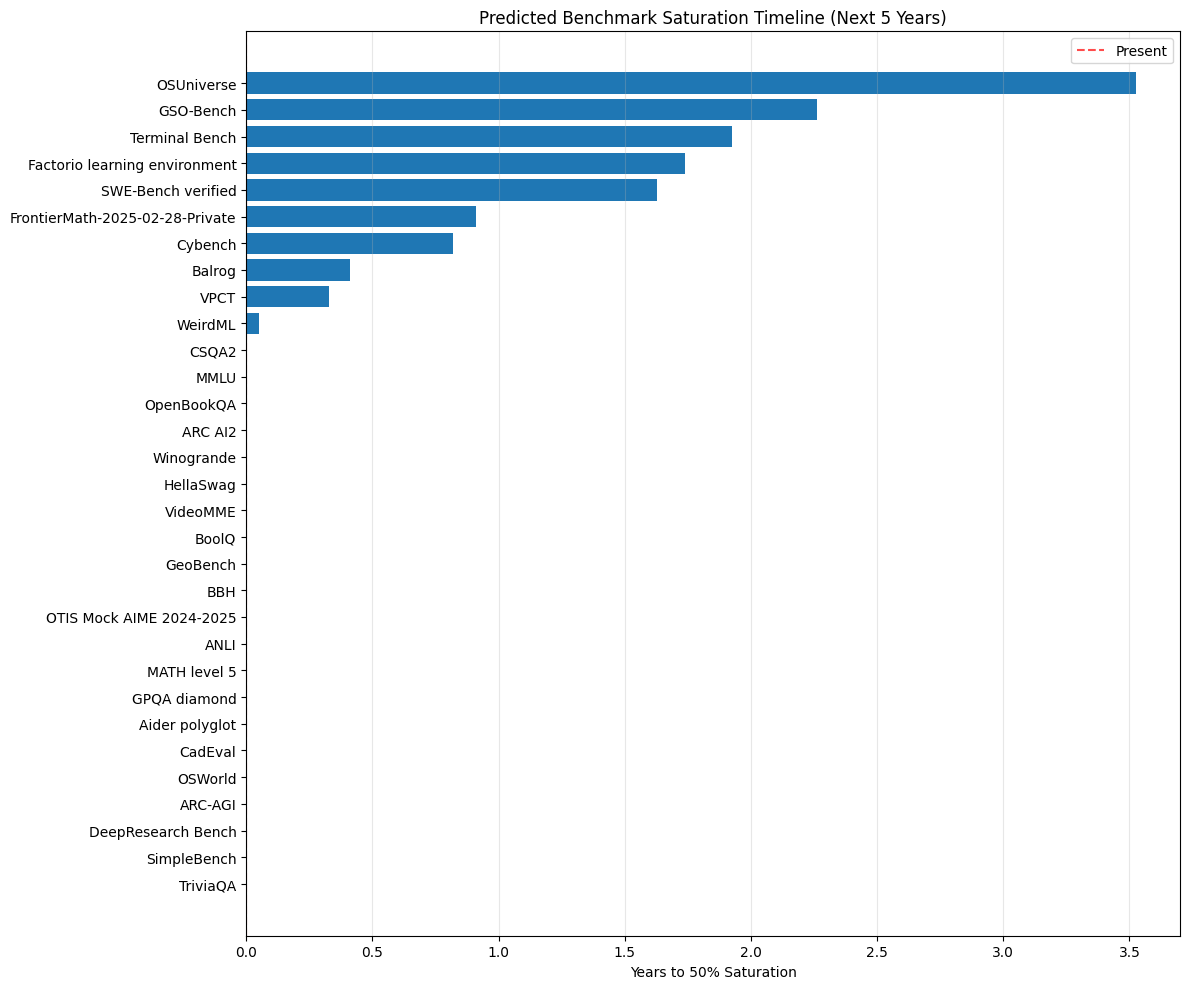

In [30]:
# Analyze benchmark saturation forecasts
saturation_forecasts = analyze_benchmark_saturation_forecasts(df_cm1, df_db1)

print("\nBenchmark Saturation Forecasts:")
print(f"  Total benchmarks analyzed: {len(saturation_forecasts)}")
print(f"  Benchmarks within 5 years: {len(saturation_forecasts[saturation_forecasts['years_to_saturation'] <= 5])}")

if len(saturation_forecasts) > 0:
    next_benchmark = saturation_forecasts.iloc[0]
    print(f"\nNext benchmark to saturate:")
    print(f"  {next_benchmark['benchmark']} in {next_benchmark['years_to_saturation']:.1f} years")
    
    print("\nTop 10 benchmarks by saturation timeline:")
    display(saturation_forecasts.head(10))
